Ali Al Kadhim and Harrison B. Prosper <br>
Department of Physics, Florida State University <br>


In [1]:
import numpy as np; import pandas as pd
import scipy as sp; import scipy.stats as st
import torch; import torch.nn as nn
from numba import njit
from sklearn.preprocessing import StandardScaler; from sklearn.model_selection import train_test_split
import matplotlib as mp; import matplotlib.pyplot as plt; 
#reset matplotlib stle/parameters
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('seaborn-deep')
mp.rcParams['agg.path.chunksize'] = 10000
font_legend = 15; font_axes=15
# %matplotlib inline
import copy; import sys; import os
from IPython.display import Image, display
import optuna
#sometimes jupyter doesnt initialize MathJax automatically for latex, so do this
import ipywidgets as wid; wid.HTMLMath('$\LaTeX$')

HTMLMath(value='$\\LaTeX$')

# Table of Contents

# Background and Problem Statement

In particle physics, the most important experiment is a counting experiment, represented by a Poisson probability model.Suppose we have a count experiment, we we observe in each bin (or channel) $k$ a count $n_k$. Given $N$ total channels, the probability of obtaining the observed result is given by the Poisson
$$ \prod_{k=1}^{N} \frac{e^{-(\epsilon_k \sigma + b_k)} (\epsilon_k \sigma + b_k)^{n_k}}{n_k !} $$

Where $\sigma$, the cross section (the parameter of interest), $b_k$ is expected background for the $k$th channel (the nuissance parameter). $\epsilon_k$ is the "acceptance parameter", for the $k$th channel, which is typically a product of the detector efficiency, branching fraction, and luminosity.


This is the prototype of many statistical models in astronomy and particle physics in which data are binned and the count in each bin consist a priori of the sum of counts from signal and background. Written in terms of the simplified 2-parameter model, the expected count in each bin $k$ takes the form

\begin{equation}
    n_{exp}=\theta+\nu
\end{equation}

Where $n_{exp}$ is the expected signal count, $\theta$ is the unknown mean count, which is the parameter of interest (the cross section), and $\nu$ is the background unknown mean count, which is the nuissance parameter. 


## The two-parameter problem

the conditional probability of observing $n$ signal counts and $m$ background counts in a *single channel or bin* is given by

$$
    P(n, m \mid \theta, v)= L(\theta, \nu) = \frac{e^{-(\theta+v)}(\theta+v)^{n}}{n !} \frac{e^{-v} v^{m}}{m !}
    \label{prob_model}
$$


Where, once the counts $n$ and $m$ have been observed becomes the likelihood $L(\theta,\nu)$. The likelihood function contains all the information from the experiment that is relevent to inference for the parameters (also known as the *likelihood principle*). The likelihood function is defined only upto an arbitrary constant, and so only ratios of likelihoods containing different values of the parameters are meaningful.

The objective now is to derive confidence intervals or limits for the parameter of interest $\theta$. What makes this challenging is the presence of the *nuissance parameter* $\nu$, which is a parameter whose value is not known precisely, and can be related to the physics or the experimental aparatus/detector. In the Bayesian approach, nuissance parameters are assigned prior probabilities $\pi(\nu) d \nu$ and are integrated out in order to arrive at the posterior for $\theta$ in a process called marginalization $L(\theta) = \int L(\theta,\nu) \pi (\nu) d \nu$. However, this produces a fair bit of subjectivity into the problem through the choice of the prior. Frequentist methods deal with nuissance parameters by profiling them the likelihood in order to arrive at their MLEs.


The typical way to arrive at confidence intervals that guarantee coverage is the Neyman-Pearson construction. However, it does not deal with the existence of nuissance parameters....


the Poisson mean$=\theta+\nu$, and the probability model *for a single bin* is given by

$$p(N,M|\theta, \nu) = \text{Poiss}(N; \theta+\nu)\text{Poiss}(M;\nu) =L(\theta, \nu)= \frac{e^{-(\theta+\nu)} (\theta+\nu)^N }{N !} \ \frac{e^{-\nu} \nu^M}{M !}$$



Where $\nu$ is the nuissance parameter, $\theta$ is the paramter of interest, for which we want to estimate confidence intervals or (upper) limits. 


## Observed Data:

   * $N$ (observed counts for signal)
   * $M$ (observed counts for background)

## Parameters:

* $\theta$: parameter of interest, proportional $\sigma$ in HEP (unknown signal mean)

* $\nu$: nuissance parameter (unknown background mean)

## Auxiliary (simulated) Data (simulated on-the-fly for each observation)

* $n$: expected signal count

* $m$: expected backround count


    
The standard procedure for removal of nuissance parameters is Bayesian marginalization, but in this study we adopt LFI with frequentest methods.

In this notebook we generate data comprising the quadruplets $\{\theta_i, \nu_i, N_i, M_i, Z_i \}$ where 

$$
\begin{align}
\theta & \sim \textrm{uniform}(0, 20), \\
\nu & \sim \textrm{uniform}(0, 20), \\
\end{align}
$$


$$
\left\{
\begin{align}
n & \sim \textrm{poisson}(\theta + \nu),\\
m & \sim \textrm{poisson}(\nu),\\
\end{align}
\right\} \rightarrow \lambda_\text{gen}(n, m \mid \theta,\nu)
$$



$$
\left\{
\begin{align}
N & \sim \textrm{uniform}(0,10),\\
M & \sim \textrm{uniform}(0, 10), \\
\end{align}
\right\} \rightarrow \lambda_D(N, M \mid \theta,\nu)
$$


$$
Z  = \mathbb{I}
\left[ \lambda_\text{gen}(n, m \mid \theta,\nu) \leq \lambda_D(N, M \mid \theta,\nu) \right],
$$

where the size of each of these samples is $B'$, $I$ is the indicator function, and $\lambda_D (D, \theta)= \lambda(N, M, \theta)$ is our chosen test statistic

$$ \lambda = - 2 \log{\frac{p(n,m|\theta, \hat{\nu}(\theta) )}{ p(n,m|\hat{\theta}, \hat{\nu}(\theta) )}} = -2 \log \frac{L_{\text{prof}} \big(n, m, \theta, \hat{\nu}(\theta) \big) }{L_{\text{prof}} \big( n, m, \hat{\theta}_{\text{MLE}}, \hat{\nu}(\theta) \big)}, \tag{1}$$

where $L_{\text{prof}} (n, m, \theta, \hat{\nu}(\theta))$ is the profiled likelihood. The maximum likelihood estimate of $\hat{\theta}$ is given by

$$\hat{\theta}_{\text{MLE}}=n-m$$.

Low-count data can sometimes yield spurious results, where the MLE of a parameter of interest $\theta$, could yield a negative result. In the case that $\theta$ is the cross section, yielding a negative result is non-physical, which leads to the ad-hoc fix: taking ignoring the MLE solution and taking $\hat{\theta}=0$ when $n<m$,


$$\hat{\theta}_{\text{non-MLE}} =\left\{
\begin{array}{ll}
    n-m & \quad  n>m \\
    0 & \quad n \le m
\end{array}
\right.
$$



$$\log{p(n,m|\theta,\nu)} = -(\theta+\nu)+n\log{(\theta+\nu)|-\nu+m\log{\nu}} + \text{constants}$$
The MLE $\hat{\nu}(\theta)$ is attained by solving $\frac{\partial \log{p(n,m|\theta,\nu)}}{ \partial \nu} =0$ leading to 

$$\hat{\nu}(\theta)=\left(g+\sqrt{g^2 + 8 m \theta} \right)/4$$
where $g \equiv n+m-2 \theta$.


Where $L_{\text{prof}} (n, m, \theta, \hat{\nu}(\theta))$ is the profiled likelihood - that is - the likelihood function when the nuissance parameters are replaced by their maximum likelihood estimates (MLE) for a given value of the parameter of interest. The test statistic in Eq. $(1)$ is used due to its well-known behavior of it converging to ti a $\chi^2_k$ variate with $k$ degrees of freedom, according to Wilk's Theorem, where $k$ is the number of free parameters (parameters of interest after the nuissance parameters have been replaecd by their MLEs). 

Clearly, our choice of using the test statistic above is motivated by the [Neyman-Pearson Lemma](https://royalsocietypublishing.org/doi/epdf/10.1098/rsta.1933.0009) Instead of using different statistics for LFI as in the [Ann Lee paper](https://arxiv.org/pdf/2107.03920.pdf), we use this one since in Ann lee's paper, for example the ACORE statistic $\Lambda\left(\mathcal{D} ; \Theta_{0}\right):=\log \frac{\sup _{\theta_{0} \in \Theta_{0}} \prod_{i=1}^{n} \mathbb{O}\left(\mathbf{X}_{i}^{\text {obs }} ; \theta_{0}\right)}{\sup _{\theta \in \Theta} \prod_{i=1}^{n} \mathbb{O}\left(\mathbf{X}_{i}^{\text {obs }} ; \theta\right)}$, since the odds $\mathbb{O}\left(\mathbf{X}_{i}^{\text {obs }}\right) $, are merely estimates of the likelihood, and not the likelihood itselt, therefore Wilk's theorem is not guaranteed to work, even if we have a large sample size. 

In [2]:
def mkdir(dir_):
    """make a directory without overwriting what's in it if it exists"""
    # assert isinstance(dir_, str)
    try:
        os.system('mkdir -p %s' % str(dir_) )
    except Exception:
        pass

In [3]:
mkdir('utils')

In [4]:
# %writefile 'src/utils.py'

def import_base_stack():
    import numpy as np; import pandas as pd
    import scipy as sp; from numba import njit

@njit
def DR(s, theta):
    return sp.special.gammainc(s, theta)

@njit
def DL(s, theta):
    return 1 - sp.special.gammainc(s+1, theta)


def L_prof(n,m,theta):
    k=1
    k1 = k+1
    k2 = 0.5/k1
    g = n+m - k1*theta
    nu_hat = k2* (g+ np.sqrt(g*g +4*k1*m*theta))
    p1 = st.poisson.pmf(n, mu = theta + nu_hat)
    p2 = st.poisson.pmf(m, mu = k * nu_hat)
    
    return p1*p2


def theta_hat(n,m, MLE=True):
    theta_hat = n-m
    
    if not MLE:
        theta_hat = theta_hat * (theta_hat > 0)
    return theta_hat

# @njit
def lambda_test(theta, n, m, MLE=True):
    Ln = L_prof(n,m,theta)
    Ld = L_prof(n,m, theta_hat(n,m, MLE))
    lambda_  = -2*np.log(Ln/Ld)
    return np.array(lambda_)

Prior to reporting the results of our method, we validate that our method by comparing it to the well-known results of Wilk's Theorem. That is, the test statistic $\lambda(\theta, n, m , \nu(\theta))$ should be distributed as a $\chi^2_1$ (a $\chi^2$ distribution with a number of degrees of freedom equal to the number of free parameters left in our problem). 

We test this theorem with our algorithm, but stopping at step 9. We then histogram the comulative distribution function (CDF) of $\lambda(\theta)$ for a given (fixed) $\theta$ and $\nu$, and compare it to the analystical CDF of a $\chi^2_1$ distribtion. The figure (below) shows that the results of our test statistic does indeed agree with what we expect from Wilk's Theorem.

In [5]:
chi2_exp_size=40

def run_sim(theta, nu, MLE, lambda_size):
    """Sample n ~ Pois(theta+nu), 
              m ~ Pois(nu), 
    and compute 
              lambda(theta, n, m)
              
    return: (n, m, lambda_), where each are np arrays of length lambda_size
    """
    n = st.poisson.rvs(theta+nu, size=lambda_size)
    m = st.poisson.rvs(nu, size=lambda_size)
    lambda_ = lambda_test(theta, n, m, MLE=MLE)
    return (n, m, lambda_)

def run_sims(points, MLE):
    """
    Run an entire simulation, that is, generate n and m from 
    run_sim above, and calculate lambda, for
    
    input: a tuple of (theta, nu) scalars
    
    Reurns:df, lambda_results
    
    where lambda_results is a list of tuples 
        (n, m, lambda_, theta, nu)
    and df is just a dataframe of [n,m,lambda,theta,nu]

    """
    lambda_results=[]
    df=pd.DataFrame()
    for p in points:
        theta, nu = p
        df['theta']=theta
        df['nu']=nu
        n, m, lambda_ = run_sim(theta, nu, MLE, lambda_size =chi2_exp_size)
        df['n'] = n
        df['m'] = m
        df['lambda']=lambda_
        lambda_results.append((n, m, lambda_, theta, nu))
    
        print( '\n \n (theta, nu) =  (%.f, %.f) \n ' % (theta, nu) )
        print(f'\t \t with associated n =  {n}, \n \n \t \t m = {m}, \n \n \t \t lambda = {lambda_}'  )
    return df, lambda_results

def plot_one(lambda_, theta, nu, ax):
    """Histogram the CDF of  lambda_t = -2log(Lp(theta)/Lp(theta_hat)), 
    for a given (fixed) theta and nu.
    Also, plot the actual CDF of a chi^2 distribution with 1 free parameter 
    (since only theta is left after we profile nu) """
    ftsize = 16; xmin= 0; xmax= 10
    ymin= 0; ymax= 1
    x_range = (xmin, xmax)
    y_range = (ymin, ymax)
    ax.set_xlim(x_range); ax.set_ylim(y_range)
    ax.set_xlabel(r'$\lambda \left(\theta,\hat{\nu}(\theta) \mid n, m \right)$',fontsize=ftsize)
    ax.set_ylabel(r'cdf$(\lambda)$', fontsize=ftsize)
    ##########HISTOGRAM CDF OF LAMBDA####################
    ax.hist(lambda_, bins=5*xmax, range=x_range,
    color=(0.8,0.8,0.9),
    density=True, cumulative=True,
    histtype='stepfilled', edgecolor='black', label=r'CDF$(\lambda)$')
    ############################################################
    ########### HISTOGRAM CDF OF THE CHI2 OF OF X WITH 1 DOF
    #x is not theta, that's the whole point of Wilks thm, x is an arbitrary RV
    x = np.arange(0, xmax, 0.2)
    y = st.chi2.cdf(x, 1)
    ax.plot(x, y, color='blue',
    linewidth=2, label=r'CDF$(\chi^2_1)$')
    # annotate
    xwid = (xmax-xmin)/12
    ywid = (ymax-ymin)/12
    xpos = xmin + xwid/2
    ypos = ymin + ywid*2
    ax.text(xpos, ypos,
    r'$ \theta = %d, \nu = %d$' % (theta, nu),
    fontsize=ftsize)
    ax.legend(loc='upper right',fontsize=15)

1. Generate one scalar $\theta$ and one scalar $\nu$
2. Generate $\lambda(\theta,\nu)$ of size $N$. Observe that the distribution of this $\lambda$ will approach the CDF of a $\chi^2_{dof}(x)$ of an RV of one dof (since $\theta$ is the only free parameter left), confirming Wilk's theorem
4. Observe that this test statistc will be dependent on the value of $\nu$ in the non-MLE case, which is not desirable since we want to be insensetive to nuissance parameters for maximal statistal power


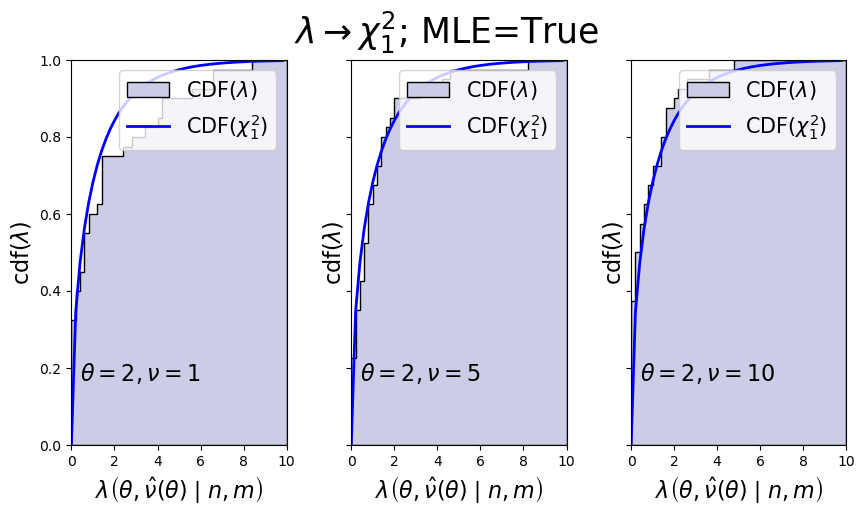

In [6]:
#points=(theta,nu)
points_1 = (2, 1)
points_2 = (2, 5)
points_3 = (2, 10)
MLE=True
_, _ , lambda_1 = run_sim(theta=points_1[0], nu=points_1[1], MLE=MLE, lambda_size=chi2_exp_size)
_, _ , lambda_2 = run_sim(theta=points_2[0], nu=points_2[1], MLE=MLE, lambda_size=chi2_exp_size)
_, _ , lambda_3 = run_sim(theta=points_3[0], nu=points_3[1], MLE=MLE, lambda_size=chi2_exp_size)

fig, ax = plt.subplots(1,3, figsize=(10,5), sharey=True)
plt.subplots_adjust(wspace=0.3)
plot_one(lambda_1, points_1[0], points_1[1], ax[0])
plot_one(lambda_2, points_2[0], points_2[1], ax[1])
plot_one(lambda_3, points_3[0], points_3[1], ax[2])
fig.suptitle(r'$\lambda \rightarrow \chi^2_1$; MLE=%s' % str(MLE), fontsize=25); 
plt.show()

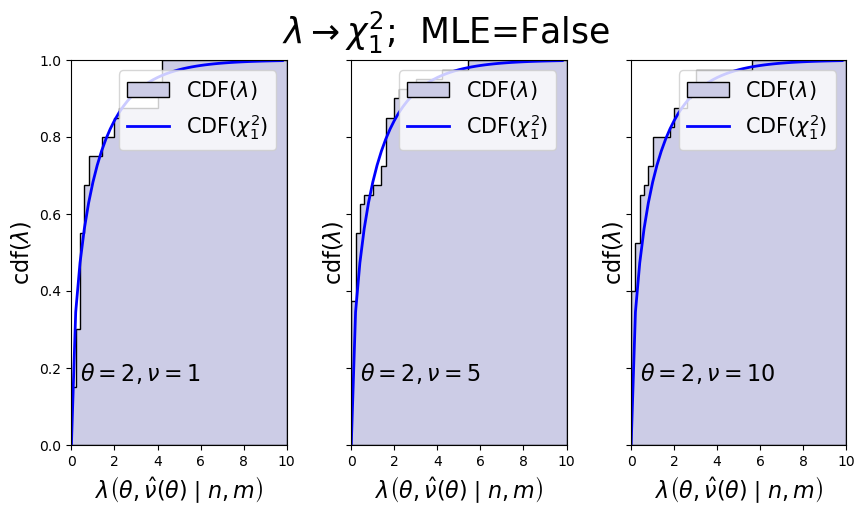

In [7]:
#points=(theta,nu)
points_1 = (2, 1)
points_2 = (2, 5)
points_3 = (2, 10)
MLE=False
_, _ , lambda_1 = run_sim(theta=points_1[0], nu=points_1[1], MLE=MLE, lambda_size=chi2_exp_size)
_, _ , lambda_2 = run_sim(theta=points_2[0], nu=points_2[1], MLE=MLE, lambda_size=chi2_exp_size)
_, _ , lambda_3 = run_sim(theta=points_3[0], nu=points_3[1], MLE=MLE, lambda_size=chi2_exp_size)

fig, ax = plt.subplots(1,3, figsize=(10,5),sharey=True)
plt.subplots_adjust(wspace=0.3)
plot_one(lambda_1, points_1[0], points_1[1], ax[0])
plot_one(lambda_2, points_2[0], points_2[1], ax[1])
plot_one(lambda_3, points_3[0], points_3[1], ax[2])
fig.suptitle(r'$\lambda \rightarrow \chi^2_1$;  MLE=False', fontsize=25); plt.show()

As shall be discussed later in this notebook, one way of calculating $p$-value for $\theta$ corresponding to an observed $\{N,M\}$ pair (which will still be dependent on $\nu$) is by calculating the test statistic at the $\{N,M\}$ pair and calculating
$$p_\theta (\nu) =\text{Prob} \big(\lambda_{gen}(n,m;\theta,\nu) \le \lambda_D(N,M;\theta,\nu) \big) =\int_{\lambda_D}^\infty f \big(\lambda_{gen}(n,m \mid \theta,\nu) \mid H_{null} \big) \ d \lambda_{gen}, \tag{2}$$

where $f$ is the PDF of $\lambda$. We see from above that the statistic $\lambda$ is an approximate sampling distribution of the $\chi^2$ PDF, proving [Wilk's theorem](https://www.jstor.org/stable/2957648?seq=1#metadata_info_tab_contents), and hence the $p$-value could also be caluclated by

$$p_\theta (\nu)=\int_{\chi^2}^\infty f(z; k) dz$$

where $k$ is the number of degrees of freedom (free parameters) which is 1 in the 2-parameter problem , and $f(z;k)$ is the $\chi^2$ PDF. This p-value can then easily be computed (e.g. yielding $p-1-\alpha ( 1- F_{\chi^2} [\theta, \nu])$, where $ F_{\chi^2}$ is the comulative $\chi^2$ distribution function (as a function of $\theta$ and $\nu$).

Generate 6 pairs (tuples) of $(\theta, \nu)$ values

In [10]:
points = [(theta, nu) for theta, nu in 
          zip(np.random.randint(low=1,high=4,size=3), 
              np.random.randint(low=0,high=4,size=3))]

In [11]:
df, results = run_sims(points, MLE=True)


 
 (theta, nu) =  (3, 1) 
 
	 	 with associated n =  [3 3 4 2 4 1 2 4 5 5 5 2 2 6 6 5 3 1 1 6 3 1 1 1 8 9 1 6 2 4 5 5 3 7 4 5 3
 6 6 2], 
 
 	 	 m = [1 0 1 1 3 1 2 0 1 3 2 1 1 2 0 0 1 0 0 0 0 2 0 2 0 1 0 1 1 0 1 1 1 0 0 1 1
 2 0 0], 
 
 	 	 lambda = [ 0.22705913 -0.         -0.          1.05217654  0.53789472  2.8587248
  1.86125037  0.30145658  0.17830477  0.12163959 -0.          1.05217654
  1.05217654  0.12957946  2.31776617  1.10825624  0.22705913  1.80277542
  1.80277542  2.31776617 -0.          3.96707375  1.80277542  3.96707375
  5.09035489  3.02906505  1.80277542  0.64125465  1.05217654  0.30145658
  0.17830477  0.17830477  0.22705913  3.70406053  0.30145658  0.17830477
  0.22705913  0.12957946  2.31776617  0.37813957]

 
 (theta, nu) =  (1, 2) 
 
	 	 with associated n =  [4 5 7 3 5 4 4 2 4 4 1 3 2 4 3 4 1 2 3 4 2 2 4 2 3 4 2 1 3 3 3 4 4 3 1 5 2
 3 4 2], 
 
 	 	 m = [1 1 0 0 1 2 3 0 0 1 1 1 1 1 4 2 2 3 1 2 5 3 3 1 4 2 2 2 2 0 0 1 0 0 2 2 1
 2 3 1], 
 
 	 	 lambda = [ 0.8775202

In [12]:
df.head()

,theta,nu,n,m,lambda
0,2,0,1,0,0.613706
1,2,0,0,0,4.000000
2,2,0,2,0,-0.000000
3,2,0,3,0,0.432791
4,2,0,3,0,0.432791


In [13]:
n, m, lambda_, theta, nu =results[1]
print(f'results[1] =  (n1, m1, lambda1, theta1, nu1) =  (  \n {n}, \n {m}, \n {lambda_}, \n {theta}, \n {nu})' )
print(f'''\n (n.shape, m.shape, lambda_.shape, theta.size, nu.size) = 
      ({n.shape}, \t {m.shape}, \t {lambda_.shape}, \t {theta.size}, \t {nu.size})''')

results[1] =  (n1, m1, lambda1, theta1, nu1) =  (  
 [4 5 7 3 5 4 4 2 4 4 1 3 2 4 3 4 1 2 3 4 2 2 4 2 3 4 2 1 3 3 3 4 4 3 1 5 2
 3 4 2], 
 [1 1 0 0 1 2 3 0 0 1 1 1 1 1 4 2 2 3 1 2 5 3 3 1 4 2 2 2 2 0 0 1 0 0 2 2 1
 2 3 1], 
 [ 0.87752024  1.68553575  7.70406053  2.15888308  1.68553575  0.17072609
 -0.          0.77258872  3.54517744  0.87752024  0.45197431  0.26469562
 -0.          0.87752024  0.56406774  0.17072609  1.25679667  0.78075725
  0.26469562  0.17072609  2.29260131  0.78075725 -0.         -0.
  0.56406774  0.17072609  0.2427715   1.25679667 -0.          2.15888308
  2.15888308  0.87752024  3.54517744  2.15888308  1.25679667  0.59696003
 -0.         -0.         -0.         -0.        ], 
 1, 
 2)

 (n.shape, m.shape, lambda_.shape, theta.size, nu.size) = 
      ((40,), 	 (40,), 	 (40,), 	 1, 	 1)


### Generate Training data (or take a look at the saved training data)

We then generate training data where the number of training examples is $B'$ according to Alg. 2 of Anne Lee et al. (shown below). The training data now has $\{\theta, \nu, N, M \} $ as training features and $Z$ as the target. We then use Pytorch to build MLP regression model with average quadratic loss to estimate the distribution of $Z$, $E[Z|\theta,\nu]$, which according to Alg. 2 is the p-value. 

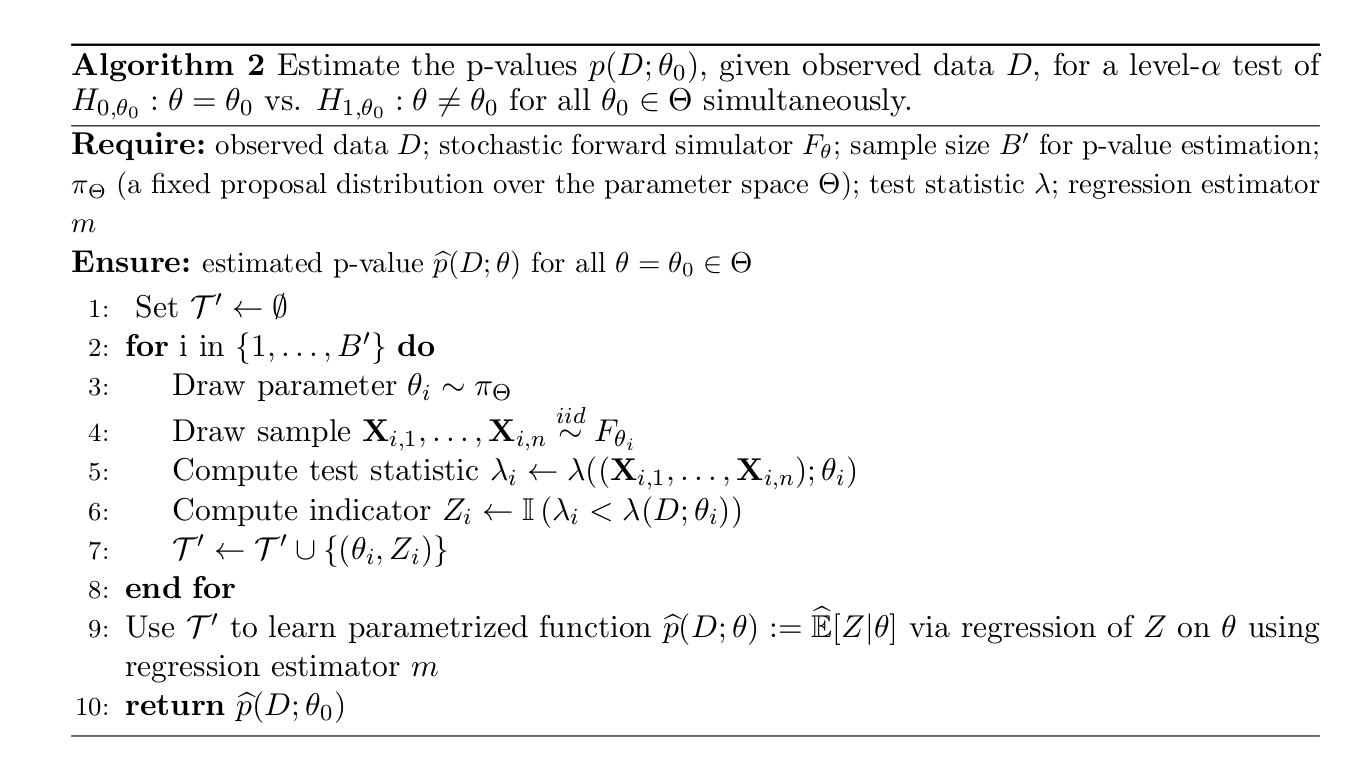

In [14]:
algorithm2 = Image('images/Algorithm2.jpg'); display(algorithm2)

As we know, the p-value is the probability under the null hypothesis $H_{null}$ (which is in this case parameterized by $\theta$) of finding data of equal or greater *incompatibility* with the predictions of $H_{null}$. Therefore, in our case, the p-value under the null hypothesis (defined by $\theta$) is given by

$$p_\theta (\nu) =\text{Prob} \big(\lambda_{gen}(n,m;\theta,\nu) \le \lambda_D(N,M;\theta,\nu) \big) =\int_{\lambda_D}^\infty f \big(\lambda_{gen}(n,m \mid \theta,\nu) \mid H_{null} \big) \ d \lambda_{gen},$$

where $f$ is the PDF of $\lambda$. In the strict frequentist approach, $\theta$ is rejected only if the $p$-value is less than the significance level of a hypothesis test $\alpha$ (i.e. accepeted if $p_\theta (\nu) \le \alpha$)

After calculating the $p$-value, one can then 

In our study we approximate this integral as the histogram of $\theta$ weighted by $Z$ divided by the histogram of $\theta$, and denote this histogram as $\mathbf{h}$. We compare this exact p-value with the outcome of our MLP, $\hat{p}(\theta, \nu, N,M)$ for the case where $\hat{\theta}$ is taken as the MLE in Fig. below we see almost perfect match.


In [15]:
train_df = pd.read_csv('data/two_parameters_theta_0_20_1000k_Examples_MLE_True.csv')
train_df.describe()

,Unnamed: 0,Z,theta,nu,N,M
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,499999.500000,0.869778,10.003676,9.993756,4.996250,5.001457
std,288675.278933,0.336548,5.774984,5.777555,2.580192,2.581568
min,0.000000,0.000000,0.000018,0.000018,1.000000,1.000000
25%,249999.750000,1.000000,5.000320,4.984808,3.000000,3.000000
50%,499999.500000,1.000000,9.997809,9.996134,5.000000,5.000000
75%,749999.250000,1.000000,15.014809,14.999267,7.000000,7.000000
max,999999.000000,1.000000,19.999995,19.999995,9.000000,9.000000


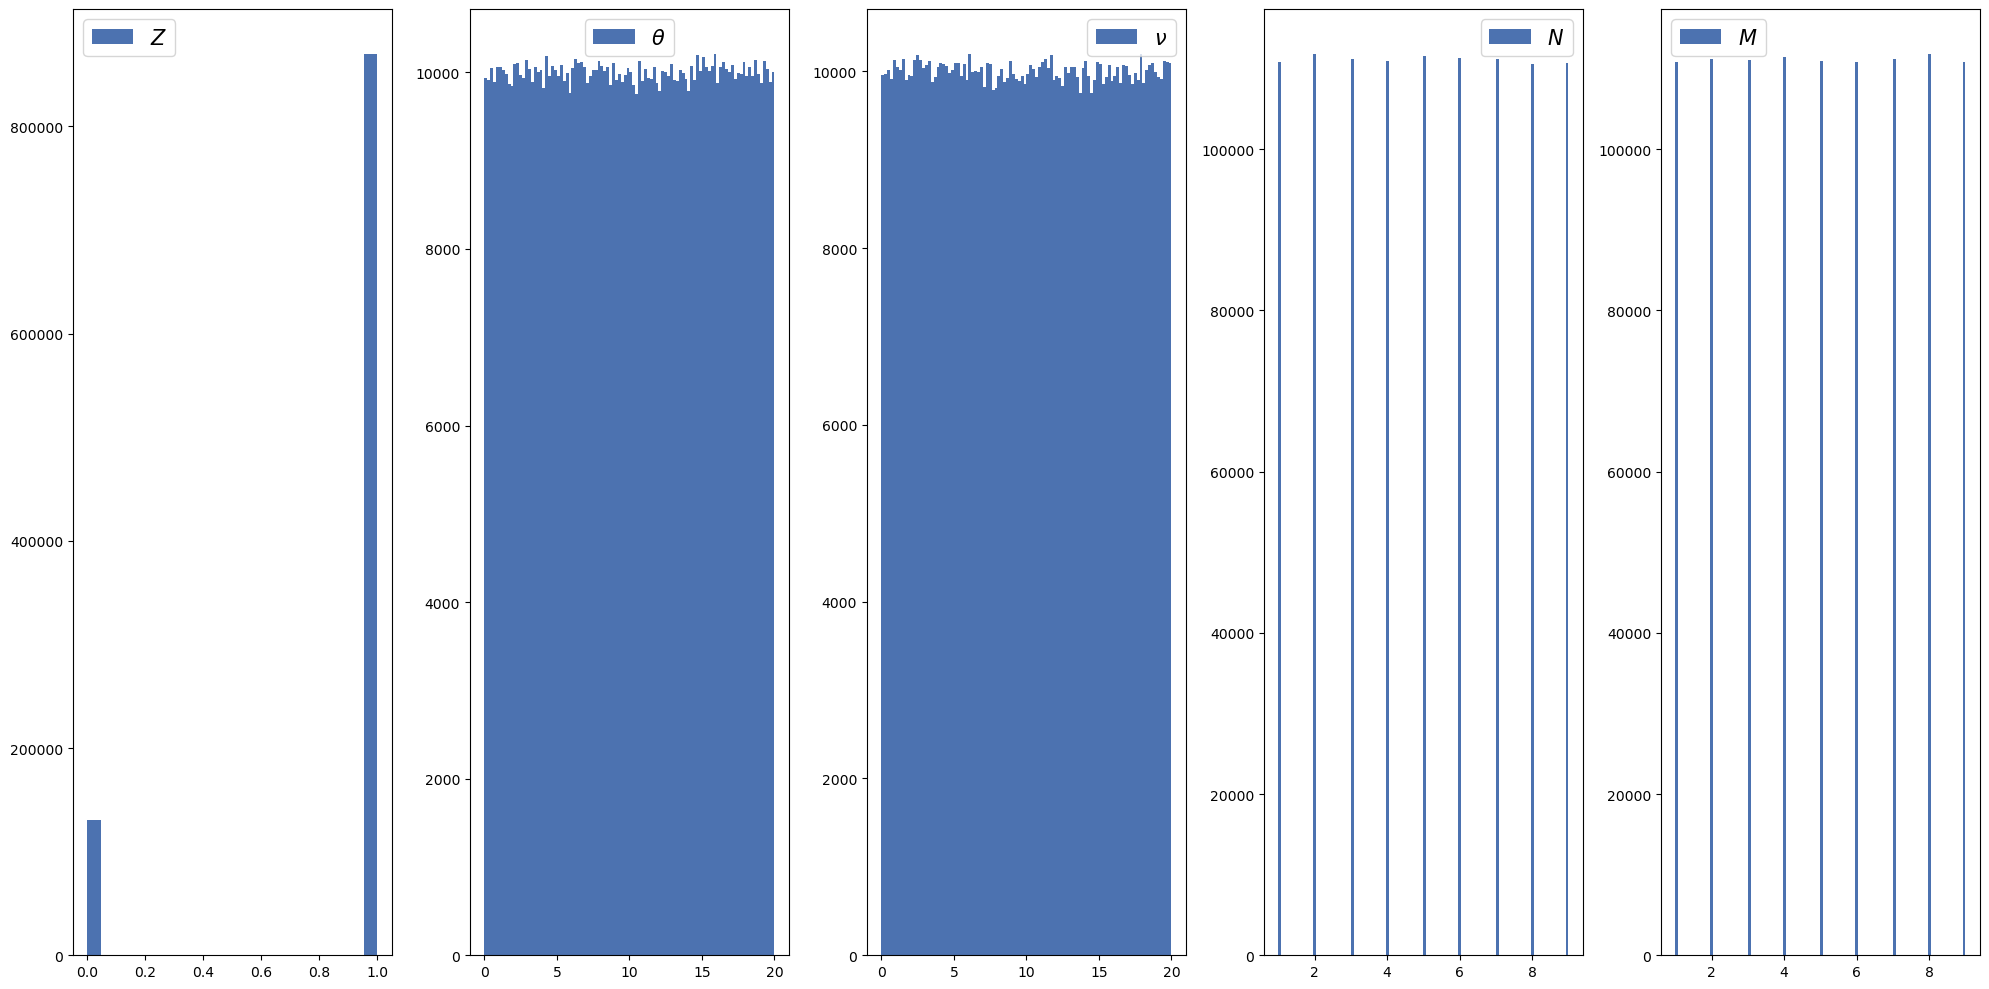

In [16]:
bins_ = 'auto'
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,10))
ax[0].hist(train_df['Z'], bins=bins_, label=r'$Z$')
ax[1].hist(train_df['theta'], bins=bins_, label=r'$\theta$')
ax[2].hist(train_df['nu'], bins=bins_, label=r'$\nu$')
ax[3].hist(train_df['N'], bins=bins_, label=r'$N$')
ax[4].hist(train_df['M'], bins=bins_, label=r'$M$')

[ax[i].legend(fontsize=font_legend) for i in range(5)]
plt.tight_layout(); plt.show()

## Generate $\{\theta_i, \nu_i, N_i, M_i, Z_i \}$  data according to:

$$
\begin{align}
\theta & \sim \textrm{uniform}(0, 20), \\
\nu & \sim \textrm{uniform}(0, 20), \\
\end{align}
$$


$$
\left\{
\begin{align}
n & \sim \textrm{poisson}(\theta + \nu),\\
m & \sim \textrm{poisson}(\nu),\\
\end{align}
\right\} \rightarrow \lambda_\text{gen}(n, m \mid \theta,\nu)
$$



$$
\left\{
\begin{align}
N & \sim \textrm{uniform}(0,10),\\
M & \sim \textrm{uniform}(0, 10), \\
\end{align}
\right\} \rightarrow \lambda_D(N, M \mid \theta,\nu)
$$


$$
Z  = \mathbb{I}
\left[ \lambda_\text{gen}(n, m \mid \theta,\nu) \leq \lambda_D(N, M \mid \theta,\nu) \right].
$$


In [17]:
thetaMin, thetaMax =  0, 20
numin, numax = 0, 20
Nmin, Nmax =  1,10
Mmin, Mmax =  1 , 10

def generate_training_data(Bprime, MLE, save_data=False):
    """Generate the training data, that is, features=[theta, nu, N, M], targets=Z"""
    #sample theta and nu from uniform(0,20)
    theta = st.uniform.rvs(thetaMin, thetaMax, size=Bprime)
    # nu = st.uniform.rvs(nuMin, nuMax, size=Bprime)
    nu= st.uniform.rvs(numin, numax, size=Bprime)
    #n,m ~ F_{\theta,\nu}, ie our simulator. sample n from a Poisson with mean theta+nu 
    n = st.poisson.rvs(theta+ nu, size=Bprime)
    #sample m from a poisson with mean nu
    m = st.poisson.rvs(nu, size=Bprime)
    #sample our observed counts (N,M), which take the place of D
    N = np.random.randint(Nmin, Nmax, size=Bprime)
    M = np.random.randint(Mmin, Mmax, size=Bprime)
    SUBSAMPLE=10
    print('n=', n[:SUBSAMPLE])
    print('m=', m[:SUBSAMPLE])
    print('N=', N[:SUBSAMPLE])
    print('M=', M[:SUBSAMPLE])
    lambda_gen = lambda_test(theta, n, m, MLE)
    print('lambda_gen= ', lambda_gen[:SUBSAMPLE])
    lambda_D = lambda_test(theta, N, M, MLE)
    print('lambda_D= ', lambda_D[:SUBSAMPLE])
    #if lambda_gen <= lambda_D: Z=1, else Z=0
    Z = (lambda_gen <= lambda_D).astype(np.int32)
    
    data_2_param = {'Z' : Z, 'theta' : theta, 'nu': nu, 'N':N, 'M':M}

    data_2_param = pd.DataFrame.from_dict(data_2_param)
    if save_data:
        data_2_param.to_csv('data/two_parameters_theta_%s_%s_%sk_Examples_MLE_%s.csv' %\
                            (str(thetaMin), str(thetaMax), str(int(Bprime/1000)), str(MLE)) )

    print('\n')
    print(data_2_param.describe())
    return data_2_param

In [18]:
Train_data_MLE_True = generate_training_data(Bprime=1000000, MLE=True, save_data=True)

n= [ 8 19 24 25 18  2 14 34 17 19]
m= [ 9  0 17 20 16  0 13 22 20 13]
N= [5 8 7 2 6 3 3 2 6 3]
M= [5 5 7 7 9 2 2 4 6 4]
lambda_gen=  [1.32188212 0.94341221 0.35590896 0.01584879 1.3625208  0.01144684
 0.37288998 0.01509279 2.22003933 0.8866015 ]
lambda_D=  [ 1.35908822  8.19503471  6.8903912   8.52415187  8.14889829  0.14035951
  1.66999237 19.32916122  2.8270121   0.40668186]


                    Z           theta              nu               N  \
count  1000000.000000  1000000.000000  1000000.000000  1000000.000000   
mean         0.869277       10.003908       10.002505        4.992945   
std          0.337097        5.776635        5.773482        2.581581   
min          0.000000        0.000003        0.000015        1.000000   
25%          1.000000        4.997640        5.003678        3.000000   
50%          1.000000       10.007441       10.005360        5.000000   
75%          1.000000       15.010142       15.000510        7.000000   
max          1.000000       19.999

-----------


# Write Custom Data Loader

In [19]:
# %writefile data/dataloader.py

def split_t_x(df, target, source):
    # change from pandas dataframe format to a numpy 
    # array of the specified types
    t = np.array(df[target])
    x = np.array(df[source])
    return t, x

def get_batch(x, batch_size):
    # the numpy function choice(length, number)
    # selects at random "batch_size" integers from 
    # the range [0, length-1] corresponding to the
    # row indices.
    rows    = np.random.choice(len(x), batch_size)
    batch_x = x[rows]
    # batch_x.T[-1] = np.random.uniform(0, 1, batch_size)
    return batch_x


def get_data_sets(simulate_data, batchsize):
    """write custom data generator because who wants to read pytorch's DataLoader source code
    (and its sometimes slow for some reason)"""
    # if simulate_data:
    #     Train_data_MLE_True = generate_training_data(Bprime=100000, MLE=True, save_data=False)
        
    # if SUBSAMPLE:
    #     data=load_df('data/TWO_PARAMETERS_TRAINING_DATA_1M.csv', SUBSAMPLE=10000)#This is MLE DATA!
    # else:
    #     data=load_df('data/TWO_PARAMETERS_TRAINING_DATA_1M.csv')
    # data=load_df('data/TWO_PARAMETERS_TRAINING_DATA_1M.csv')
    data = pd.read_csv('data/two_parameters_theta_0_20_1000k_Examples_MLE_True.csv', 
                 # nrows=SUBSAMPLE,
                 usecols=['Z','theta','nu', 'N', 'M']
                )
    train_data, test_data = train_test_split(data, 
                                         test_size=0.02)
    #split the train data (0.8 of whole set) again into 0.8*0.8=0.64 of whole set
    # train_data, valid_data = train_test_split(train_data, test_size=0.2)
    train_data = train_data.reset_index(drop=True)
    # valid_data = valid_data.reset_index(drop=True)
    test_data  = test_data.reset_index(drop=True)

    target='Z'
    source = ['theta','nu','N','M']
    train_t, train_x = split_t_x(train_data, target=target, source=source)
    # valid_t, valid_x = split_t_x(valid_data, target=target, source=source)
    test_t,  test_x  = split_t_x(test_data,  target=target, source=source)
    
    def training_set_features():
            #start with an infinite loop, so that you can keep calling next (i.e. set = train_set(); set.next() ) until you run out of training examples
        while True:
            #get a random batch of the defined size
            batch_x = get_batch(train_x, batchsize)
            #print('batch_x', batch_x)
            #index of one of the items in our examples
            yield batch_x

    def evaluation_set_features():
        #start with an infinite loop, so that you can keep calling next (i.e. set = train_set(); set.next() ) until you run out of training examples
        while True:
            batch_x = get_batch(test_x,batchsize)
            #index of one of the items in our examples
            yield batch_x


    def training_set_targets():
            #start with an infinite loop, so that you can keep calling next (i.e. set = train_set(); set.next() ) until you run out of training examples
        while True:
            #get a random batch of the defined size
            batch_x = get_batch(train_t, batchsize)
            #print('batch_x', batch_x)
            #index of one of the items in our examples
            yield batch_x

    def evaluation_set_targets():
            #start with an infinite loop, so that you can keep calling next (i.e. set = train_set(); set.next() ) until you run out of training examples
        while True:
            #get a random batch of the defined size
            batch_x = get_batch(test_t, batchsize)
            #print('batch_x', batch_x)
            #index of one of the items in our examples
            yield batch_x

    return training_set_features, training_set_targets, evaluation_set_features, evaluation_set_targets

In [20]:
training_set_features, training_set_targets, evaluation_set_features, evaluation_set_targets = get_data_sets(simulate_data=True, batchsize=300)

first_features_batch = next(training_set_features())
sample_x =first_features_batch
print('first features batch \n', first_features_batch[:5])
print('\nfirst features batch shape \n', first_features_batch.shape)

first features batch 
 [[ 7.05260817 19.28747848  7.          9.        ]
 [ 1.35740171  3.71962183  2.          5.        ]
 [11.51469119  8.63460637  5.          2.        ]
 [14.02377962 16.77630767  5.          8.        ]
 [ 6.94452964  7.14484569  8.          9.        ]]

first features batch shape 
 (300, 4)


In [21]:
def binsize(data_df_or_Bprime):
    """ decide on the number of bins in a histogram according to Struge's rule"""
    if isinstance(data_df_or_Bprime,pd.core.frame.DataFrame):
        bin_count = int(np.ceil(np.log2(data_df_or_Bprime.shape[0])) + 1)
    elif isinstance(data_df_or_Bprime, int):
        bin_count = int(np.ceil(np.log2(data_df_or_Bprime)) + 1)
    return bin_count

Plot the histogrammed function the histogrammed function $h(\tilde{\theta}, \nu, N, M) = h(\theta_{min}, \theta_{max}, \nu, N, M)$ where $\tilde{\theta}$ means that it is simulated (inside the function).

In [22]:
def make_hist_data(Bprime,
              thetamin, thetamax,
              nu, N, M,
                nbins,
             MLE=True):

    theta = st.uniform.rvs(thetamin, thetamax, size=Bprime)
    n = st.poisson.rvs(theta + nu, size=Bprime)
    m = st.poisson.rvs(nu, size=Bprime)
    
    Z = (lambda_test(theta, n, m, MLE=MLE) < 
         lambda_test(theta, N, M, MLE=MLE)).astype(np.int32)

    thetarange = (thetamin, thetamax)
    # bins = binsize(Bprime)

    # weighted histogram   (count the number of ones per bin)
    y1, bb = np.histogram(theta, 
                          bins=nbins, 
                          range=thetarange, 
                          weights=Z)
    
    # unweighted histogram (count number of ones and zeros per bin)
    yt, _ = np.histogram(theta, 
                         bins=nbins, 
                         range=thetarange)

    y =  y1 / yt    
    
    return y, bb

In [23]:
h, h_bins = make_hist_data(Bprime=1000, 
                           thetamin=0,thetamax=20, 
                           nu=3,N=1,M=1,
                           nbins=200, MLE=True)
h

array([0.        , 0.2       , 0.        , 0.25      , 0.22222222,
       0.33333333, 0.5       , 0.33333333, 0.22222222, 0.375     ,
       0.        , 0.66666667, 1.        , 1.        , 0.8       ,
       1.        , 0.66666667, 1.        , 0.5       , 1.        ,
       1.        , 1.        , 0.5       , 0.71428571, 1.        ,
       0.85714286, 0.8       , 1.        , 1.        , 0.83333333,
       1.        , 0.8       , 1.        , 0.8       , 0.875     ,
       1.        , 1.        , 0.66666667, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.75      ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [24]:
def plot_one_hist(Bprime, thetamin, thetamax, nu, N, M, MLE, nbins, ax):
    counts, bins= make_hist_data(Bprime,
              thetamin, thetamax,
              nu, N, M,
            nbins,
             MLE)
    bin_centers = (bins[1:]+bins[:-1])/2
    ax.plot(bin_centers, counts, label= r'$\mathbf{h}$ Example', lw=3)
    ax.set_xlabel(r'$\theta$',fontsize=font_axes)
    ax.set_ylabel(r'$E(Z|\theta,\nu)$',fontsize=font_axes)
    ax.legend(loc='center right',fontsize=font_legend)

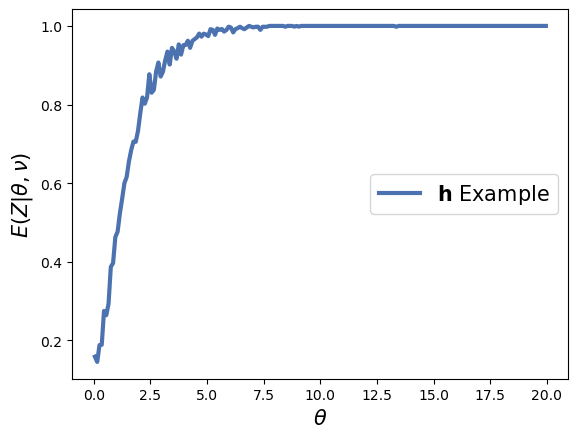

In [25]:
fig= plt.figure();ax=fig.add_subplot()

#Example:
plot_one_hist(Bprime=100000, thetamin=0,thetamax=20, nu=3,N=1,M=1,MLE=True, nbins=200, ax=ax)
plt.show()

### Plot the histogrammed approximations for the MLE vs non-MLE cases for a single value of $\mathbf{\nu}$

In [26]:
def plot_data_one_nu(Bprime, thetamin, thetamax, nu, D, MLE, 
              FONTSIZE=15,
              func=None,
              fgsize=(10, 6)):
    
    # make room for 6 sub-plots
    fig, ax = plt.subplots(nrows=2, 
                           ncols=3, 
                           figsize=fgsize)
    
    # padding
    plt.subplots_adjust(hspace=0.01)
    plt.subplots_adjust(wspace=0.20)
    
    # use flatten() to convert a numpy array of 
    # shape (nrows, ncols) to a 1-d array. 
    ax = ax.flatten()
    
    for j, (N, M) in enumerate(D):
        
        y, bb = make_hist_data(Bprime,
                              thetamin, thetamax,
                              nu, N, M,
                              nbins=200,
                              MLE=True)
    
        ax[j].set_xlim(thetamin, thetamax-5)
        ax[j].set_ylim(0, 1)
        ax[j].set_xlabel(r'$\theta$', fontsize=FONTSIZE)
        ax[j].set_ylabel(r'$E(Z|\theta, \nu)$', fontsize=FONTSIZE)
        
        x = (bb[1:]+bb[:-1])/2
        ax[j].plot(x, y, 'b', lw=2, label='$\mathbf{h}$, MLE', alpha=0.3)
        #h is histogram approximation

        y_nonMLE, bb_nonMLE = make_hist_data(Bprime,
                              thetamin, thetamax,
                              nu, N, M,
                              nbins=200,
                              MLE=False)
        
        
        x_nonMLE = (bb_nonMLE[1:]+bb_nonMLE[:-1])/2
        ax[j].plot(x_nonMLE, y_nonMLE, 'r', lw=2, label='$\mathbf{h}$, non-MLE',alpha=0.3)
        
        
        if func:
            p, _ = func(nu, N, M)
            ax[j].plot(x, p, 'r', lw=2, label='f')
            #f is model approximation
        
        ax[j].grid(True, which="both", linestyle='-')
        ax[j].text(5.1, 0.42, r'$N, M = %d, %d$' % (N, M), fontsize=font_legend-3
                   # fontsize=FONTSIZE
                  ) 

        ax[j].text(5.1, 0.30, r'$\nu = %5.1f$' % nu, fontsize=font_legend-3
                   # fontsize=FONTSIZE
                  ) 

        ax[j].legend(loc='upper right',fontsize=font_legend-3)
        
    # hide unused sub-plots
    for k in range(j+1, len(ax)):
        ax[k].set_visible(False)
    
    plt.tight_layout()
    plt.show()


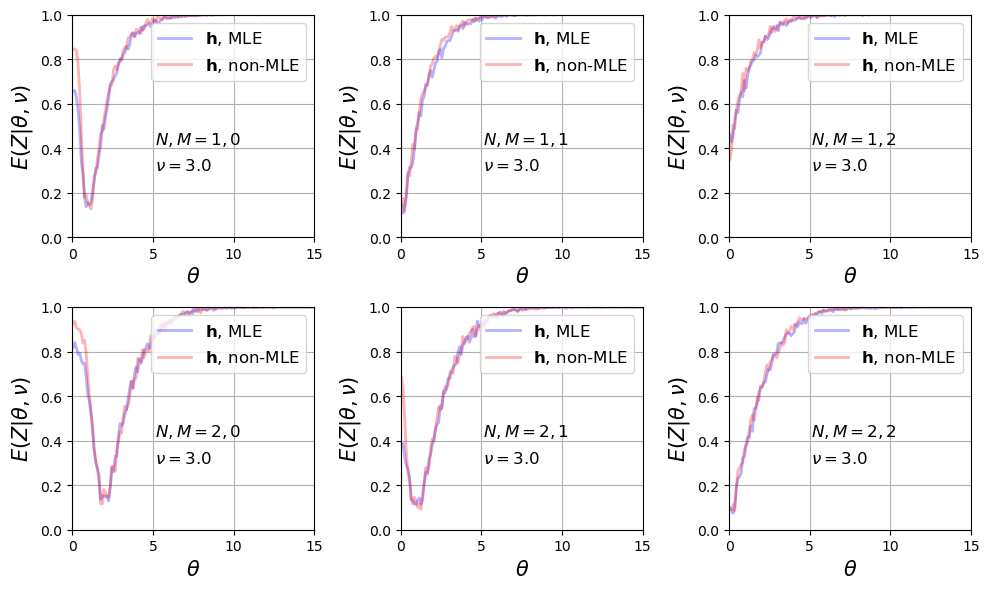

In [31]:
D = [ (N, M) for N in range(1,3) for M in range(3)]
plot_data_one_nu(Bprime=100000, thetamin=0, thetamax=20, nu=3, D=D, MLE=True)

### Plot the histogrammed approximation $\mathbf{h}$, for the MLE vs non-MLE cases for multiple values of $\mathbf{\nu}$, indicating the dependence on the nuissance parameter

In [32]:
def plot_data(Bprime, thetamin, thetamax, D, MLE, 
              FONTSIZE=15,
              func=None,
              fgsize=(15, 13)):
    
    # make room for 6 sub-plots
    fig, ax = plt.subplots(nrows=6, 
                           ncols=2, 
                           figsize=fgsize)
    
    # padding
    plt.subplots_adjust(hspace=0.01)
    plt.subplots_adjust(wspace=0.20)
    
    # use flatten() to convert a numpy array of 
    # shape (nrows, ncols) to a 1-d array. 
    # ax = ax.flatten()
    
    for j, (N, M) in enumerate(D):
        NU1=1
        y, bb = make_hist_data(Bprime,
                              thetamin, thetamax,
                               NU1, N, M,
                              nbins=200,
                              MLE=True)
    
        ax[j, 0].set_xlim(thetamin, thetamax-5)
        ax[j, 0].set_ylim(0, 1.03)
        ax[j, 0].set_xlabel(r'$\theta$', fontsize=FONTSIZE)
        ax[j, 0].set_ylabel(r'$E(Z|\theta, \nu)$', fontsize=FONTSIZE)
        
        x = (bb[1:]+bb[:-1])/2
        ax[j, 0].plot(x, y, 'b', lw=2, label='$\mathbf{h}$, MLE', alpha=0.45)
        #h is histogram approximation

        y_nonMLE, bb_nonMLE = make_hist_data(Bprime,
                              thetamin, thetamax,
                              NU1, N, M,
                              nbins=200,
                              MLE=False)
        
        
        x_nonMLE = (bb_nonMLE[1:]+bb_nonMLE[:-1])/2
        ax[j, 0].plot(x_nonMLE, y_nonMLE, 'r', lw=2, label='$\mathbf{h}$, non-MLE',alpha=0.45)
        
        ax[j, 0].grid(True, which="both", linestyle='-')
        ax[j, 0].text(6.1, 0.42, r'$N, M = %d, %d$' % (N, M), 
                   # fontsize=FONTSIZE
                  ) 

        ax[j, 0].text(6.1, 0.30, r'$\nu = %5.1f$' % NU1, 
                   # fontsize=FONTSIZE
                  ) 

        ax[j, 0].legend(loc='upper right', fontsize=font_legend-3)
        ############define second nu value to see difference
        NU2=9
        y, bb = make_hist_data(Bprime,
                              thetamin, thetamax,
                               NU2, N, M,
                              nbins=200,
                              MLE=True)
    
        ax[j, 1].set_xlim(thetamin, thetamax-5)
        ax[j, 1].set_ylim(0, 1.03)
        ax[j, 1].set_xlabel(r'$\theta$', fontsize=FONTSIZE)
        ax[j, 1].set_ylabel(r'$E(Z|\theta, \nu)$', fontsize=FONTSIZE)
        
        x = (bb[1:]+bb[:-1])/2
        ax[j, 1].plot(x, y, 'b', lw=2, label='$\mathbf{h}$, MLE', alpha=0.45)
        #h is histogram approximation

        y_nonMLE, bb_nonMLE = make_hist_data(Bprime,
                              thetamin, thetamax,
                              NU1, N, M,
                              nbins=200,
                              MLE=False)
        
        
        x_nonMLE = (bb_nonMLE[1:]+bb_nonMLE[:-1])/2
        ax[j, 1].plot(x_nonMLE, y_nonMLE, 'r', lw=2, label='$\mathbf{h}$, non-MLE',alpha=0.45)
        
         
        ax[j, 1].grid(True, which="both", linestyle='-')
        ax[j, 1].text(6.1, 0.42, r'$N, M = %d, %d$' % (N, M), 
                   # fontsize=FONTSIZE
                  ) 

        ax[j, 1].text(6.1, 0.30, r'$\nu = %5.1f$' % NU2, 
                   # fontsize=FONTSIZE
                  ) 

        ax[j, 1].legend(loc='upper right', fontsize=font_legend-3)
        
        if func:
            p, _ = func(nu, N, M)
            ax[j, 0].plot(x, p, 'r', lw=2, label='f')
            #f is model approximation
        

        
    # hide unused sub-plots
    for k in range(j+1, len(ax)):
        ax[k].set_visible(False)
    
    plt.tight_layout()
    plt.show()

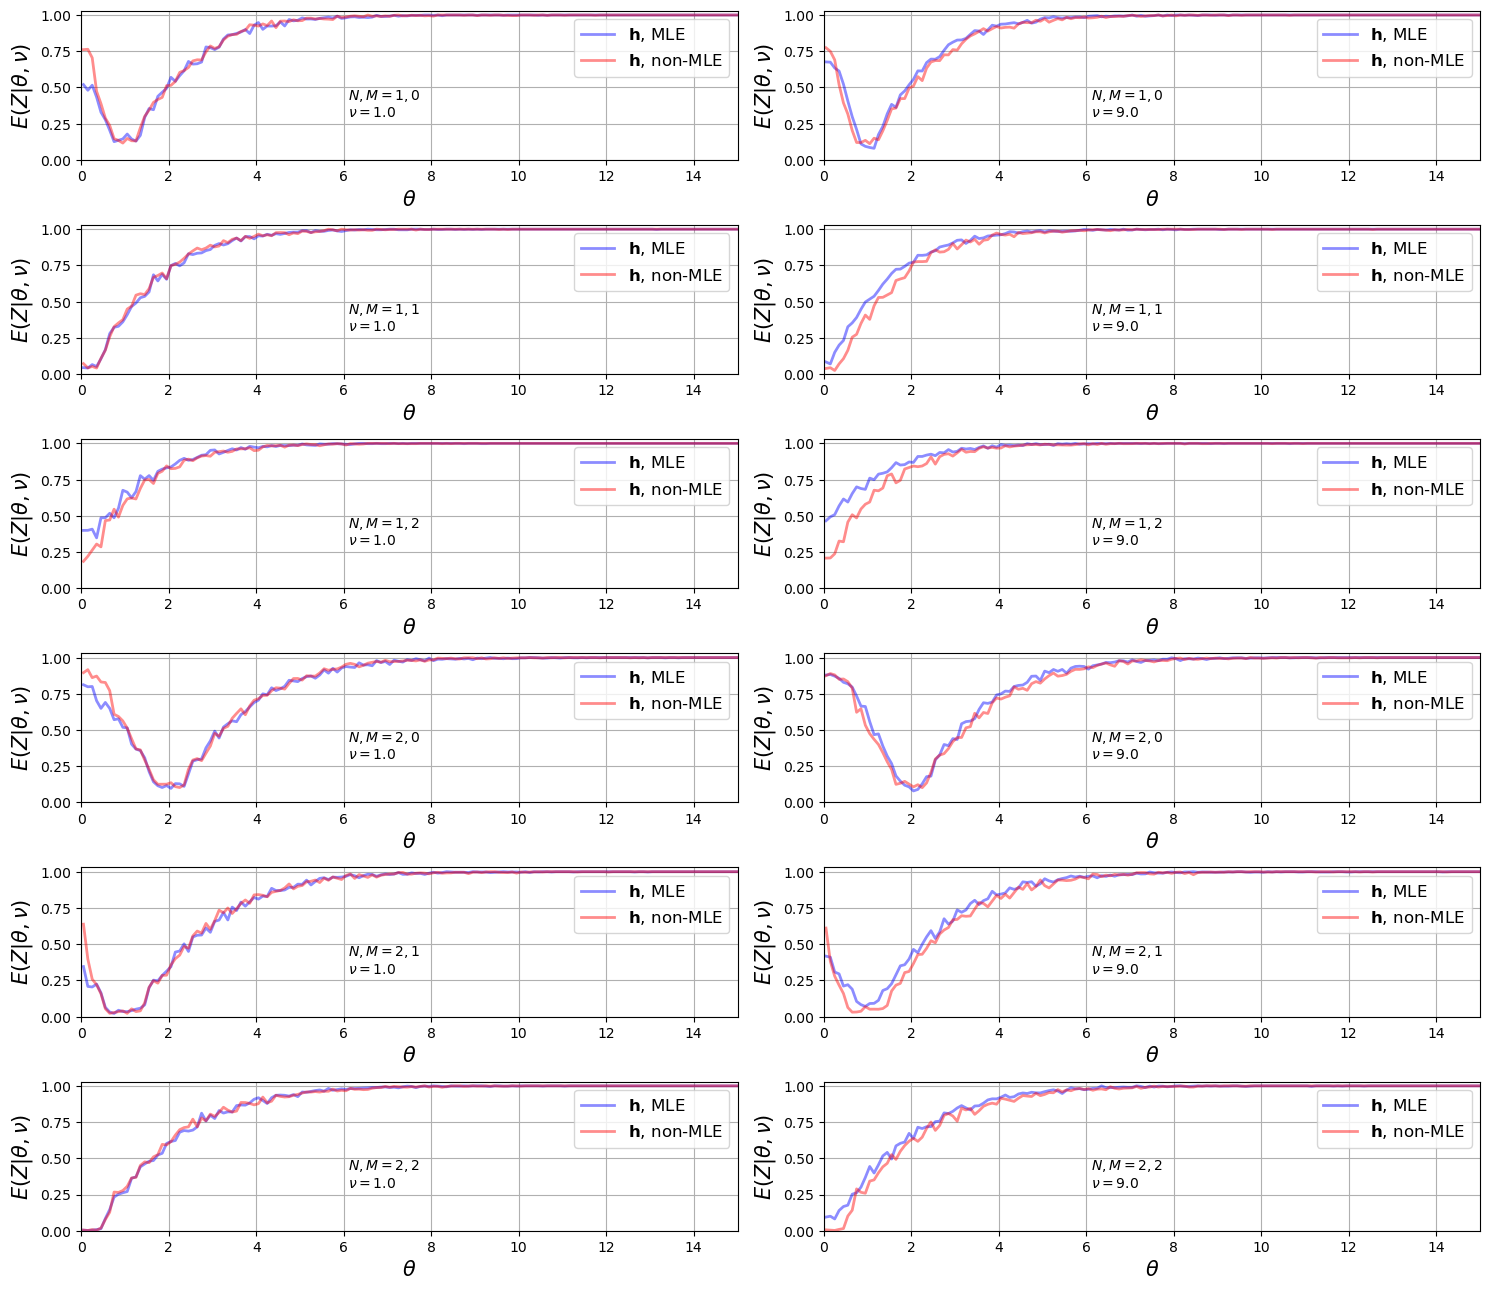

In [33]:
D = [ (N, M) for N in range(1,3) for M in range(3)]
plot_data(Bprime=100000, thetamin=0, thetamax=20, D=D, MLE=True)

--------------------
------------

# ML

It is important to always remember the following formula:

$$ \int \frac{\partial L}{\partial f} \ p(y|x) \ dy =0$$

Where $L$, $f$ are the loss function and the model (neural network/classifier/regressor, etc), and $p(y|x)$ the PDF of targets $y$ that we want to estimate, given features $x$.

In [27]:
def getwholedata(MLE_or_nonMLE, valid=False):
    if MLE:
        data = pd.read_csv('data/two_parameters_theta_0_20_1000k_Examples_MLE_True.csv', 
                     # nrows=SUBSAMPLE,
                     usecols=['Z','theta','nu', 'N', 'M']
                    )
        
    else:
        data = pd.read_csv('data/two_parameters_theta_0_20_1000k_Examples_MLE_False.csv', 
             # nrows=SUBSAMPLE,
             usecols=['Z','theta','nu', 'N', 'M']
            )
    train_data, test_data = train_test_split(data, test_size=0.2)
    #split the train data (0.8 of whole set) again into 0.8*0.8=0.64 of whole set
    

    train_data = train_data.reset_index(drop=True)
    test_data  = test_data.reset_index(drop=True)

    target='Z'
    source = ['theta','nu','N','M']

    train_t, train_x = split_t_x(train_data, target=target, source=source)
    test_t,  test_x  = split_t_x(test_data,  target=target, source=source)
    print('train_t shape = ', train_t.shape, '\n')
    print('train_x shape = ', train_x.shape, '\n')
    
    if valid:
        #if you want to also make a validation data set
        train_data, valid_data = train_test_split(train_data, test_size=0.2)
        valid_data = valid_data.reset_index(drop=True)
        valid_t, valid_x = split_t_x(valid_data, target=target, source=source)

        
    return train_t, train_x, test_t,  test_x


# n_iterations=50

### Define Model $\mathbf{f}$, which will approximate the expectation value above

In [28]:
class Model(nn.Module):
    
    def __init__(self, n_inputs=4, n_nodes=20, n_layers=5):

        # call constructor of base (or super, or parent) class
        super(Model, self).__init__()

        self.layers = []
        
        # create input layer
        self.layer0 = nn.Linear(n_inputs, n_nodes)
        self.layers.append(self.layer0)

        # create "hidden" layers
        for l in range(1, n_layers):
            cmd = 'self.layer%d = nn.Linear(%d, %d)' % \
            (l, n_nodes, n_nodes)
            exec(cmd)
            cmd = 'self.layers.append(self.layer%d)' % l
            exec(cmd)
          
        # create output layer
        cmd = 'self.layer%d = nn.Linear(%d, 1)' % (n_layers, n_nodes)
        exec(cmd)
        cmd = 'self.layers.append(self.layer%d)' % n_layers
        exec(cmd)

    # define (required) method to compute output of network
    def forward(self, x):
        y = x
        for layer in self.layers[:-1]:
            y = layer(y)
            y = torch.relu(y)
        y = self.layers[-1](y)
        y = torch.sigmoid(y)
        return y

model_ = Model()
print(model_)

Model(
  (layer0): Linear(in_features=4, out_features=20, bias=True)
  (layer1): Linear(in_features=20, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=20, bias=True)
  (layer4): Linear(in_features=20, out_features=20, bias=True)
  (layer5): Linear(in_features=20, out_features=1, bias=True)
)


In [43]:
def average_quadratic_loss(f, t, x):
    # f and t must be of the same shape
    return  torch.mean((f - t)**2)
def average_loss(f, t):
    # f and t must be of the same shape
    return  torch.mean((f - t)**2)

def validate(model, avloss, inputs, targets):
    # make sure we set evaluation mode so that any training specific
    # operations are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x and t
        x = torch.from_numpy(inputs).float()
        t = torch.from_numpy(targets).float()
        # remember to reshape!
        o = model(x).reshape(t.shape)
    return avloss(o, t, x)


def get_features_training_batch(x, t, batch_size):
    # the numpy function choice(length, number)
    # selects at random "batch_size" integers from 
    # the range [0, length-1] corresponding to the
    # row indices.
    rows    = np.random.choice(len(x), batch_size)
    batch_x = x[rows]
    batch_t = t[rows]
    # batch_x.T[-1] = np.random.uniform(0, 1, batch_size)
    return (batch_x, batch_t)


def train(model, optimizer, avloss,
          batch_size, 
          n_iterations, traces, 
          step, window, MLE):
    
    # to keep track of average losses
    xx, yy_t, yy_v, yy_v_avg = traces
    

    
    if MLE:
        train_t, train_x, test_t,  test_x = getwholedata(MLE_or_nonMLE=True, valid=False)
    else:
        train_t, train_x, test_t,  test_x = getwholedata(MLE_or_nonMLE=False, valid=False)
        
    n = len(test_x)
    print('Iteration vs average loss')
    print("%10s\t%10s\t%10s" % \
          ('iteration', 'train-set', 'valid-set'))
    
    # training_set_features, training_set_targets, evaluation_set_features, evaluation_set_targets = get_data_sets(simulate_data=False, batchsize=batch_size)
    
    for ii in range(n_iterations):

        # set mode to training so that training specific 
        # operations such as dropout are enabled.

        
        model.train()
        
        # get a random sample (a batch) of data (as numpy arrays)
        
        #Harrison-like Loader
        batch_x, batch_t = get_features_training_batch(train_x, train_t, batch_size)
        
        #Or Ali's Loader
        # batch_x, batch_t = next(training_set_features()), next(training_set_targets())
        # batch_x_eval, batch_t_eval = next(evaluation_set_features()), next(evaluation_set_targets())

        with torch.no_grad(): # no need to compute gradients 
            # wrt. x and t
            x = torch.from_numpy(batch_x).float()
            t = torch.from_numpy(batch_t).float()      


        outputs = model(x).reshape(t.shape)
   
        # compute a noisy approximation to the average loss
        empirical_risk = avloss(outputs, t, x)
        
        # use automatic differentiation to compute a 
        # noisy approximation of the local gradient
        optimizer.zero_grad()       # clear previous gradients
        empirical_risk.backward()   # compute gradients
        
        # finally, advance one step in the direction of steepest 
        # descent, using the noisy local gradient. 
        optimizer.step()            # move one step
        
        if ii % step == 0:
            
            
            #using Harrison-like loader
            acc_t = validate(model, avloss, train_x[:n], train_t[:n]) 
            acc_v = validate(model, avloss, test_x[:n], test_t[:n])
            
            #using Ali's loader
            # acc_t = validate(model, avloss, batch_x, batch_t) 
            # acc_v = validate(model, avloss, batch_x_eval, batch_t_eval)
            

            yy_t.append(acc_t)
            yy_v.append(acc_v)
            
            # compute running average for validation data
            len_yy_v = len(yy_v)
            if   len_yy_v < window:
                yy_v_avg.append( yy_v[-1] )
            elif len_yy_v == window:
                yy_v_avg.append( sum(yy_v) / window )
            else:
                acc_v_avg  = yy_v_avg[-1] * window
                acc_v_avg += yy_v[-1] - yy_v[-window-1]
                yy_v_avg.append(acc_v_avg / window)
                        
            if len(xx) < 1:
                xx.append(0)
                print("%10d\t%10.6f\t%10.6f" % \
                      (xx[-1], yy_t[-1], yy_v[-1]))
            else:
                xx.append(xx[-1] + step)
                    
                print("\r%10d\t%10.6f\t%10.6f\t%10.6f" % \
                          (xx[-1], yy_t[-1], yy_v[-1], yy_v_avg[-1]), 
                      end='')
            
    print()      
    return (xx, yy_t, yy_v, yy_v_avg)

def plot_average_loss(traces, ftsize=18,save_loss_plots=False):
    
    xx, yy_t, yy_v, yy_v_avg = traces
    
    # create an empty figure
    fig = plt.figure(figsize=(6, 4.5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)

    ax.set_title("Average loss")
    
    ax.plot(xx, yy_t, 'b', lw=2, label='Training')
    ax.plot(xx, yy_v, 'r', lw=2, label='Validation')
    #ax.plot(xx, yy_v_avg, 'g', lw=2, label='Running average')

    ax.set_xlabel('Iterations', fontsize=ftsize)
    ax.set_ylabel('average loss', fontsize=ftsize)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which="both", linestyle='-')
    ax.legend(loc='upper right')
    if save_loss_plots:
        plt.savefig('images/loss_curves/IQN_'+N+T+'_Consecutive_2.png')
        print('\nloss curve saved in images/loss_curves/IQN_'+N+target+'_Consecutive.png')
    # if show_loss_plots:
    plt.show()

Define my regularized regression model. Since the values are on the same scales, it is not necessary to include batchnormalization or to normalize the data

In [30]:
class RegularizedRegressionModel(nn.Module):
    #inherit from the super class
    def __init__(self, nfeatures, ntargets, nlayers, hidden_size, dropout):
        super().__init__()
        layers = []
        for _ in range(nlayers):
            if len(layers) ==0:
                #inital layer has to have size of input features as its input layer
                #its output layer can have any size but it must match the size of the input layer of the next linear layer
                #here we choose its output layer as the hidden size (fully connected)
                layers.append(nn.Linear(nfeatures, hidden_size))
                #batch normalization
                # layers.append(nn.BatchNorm1d(hidden_size))
                #Dropout seems to worsen model performance
                layers.append(nn.Dropout(dropout))
                #ReLU activation 
                layers.append(nn.ReLU())
            else:
                #if this is not the first layer (we dont have layers)
                layers.append(nn.Linear(hidden_size, hidden_size))
                # layers.append(nn.BatchNorm1d(hidden_size))
                #Dropout seems to worsen model performance
                layers.append(nn.Dropout(dropout))
                layers.append(nn.ReLU())
                #output layer:
        layers.append(nn.Linear(hidden_size, ntargets)) 

        # ONLY IF ITS A CLASSIFICATION, ADD SIGMOID
        layers.append(nn.Sigmoid())
            #we have defined sequential model using the layers in oulist 
        self.model = nn.Sequential(*layers)

    
    def forward(self, x):
        return self.model(x)

# Make a hyperparameter Tuning Workflow

Use Optuna ( [axriv:1907.10902](https://arxiv.org/pdf/1907.10902.pdf) ) for hyperparameter tuning. The search space for the hyperparameters that I'm tuning is defined in the params dictionary:

```python
    params = {
      "nlayers": trial.suggest_int("nlayers",1,13),      
      "hidden_size": trial.suggest_int("hidden_size", 2, 130),
      "dropout": trial.suggest_float("dropout", 0.1,0.5),
      "optimizer_name" : trial.suggest_categorical("optimizer_name", ["Adam", "RMSprop"]),
      "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-2),
      "batch_size": trial.suggest_int("batch_size", 1000, 10000)

    }
```

In [31]:
class Engine:
    """loss, training and evaluation"""
    def __init__(self, model, optimizer, batch_size):
                 #, device):
        self.model = model
        #self.device= device
        self.optimizer = optimizer
        self.batch_size=batch_size
        
    #the loss function returns the loss function. It is a static method so it doesn't need self
    # @staticmethod
    # def loss_fun(targets, outputs):
    #   tau = torch.rand(outputs.shape)
    #   return torch.mean(torch.where(targets >= outputs, 
    #                                   tau * (targets - outputs), 
    #                                   (1 - tau)*(outputs - targets)))

#     This loss combines a Sigmoid layer and the BCELoss in one single class. This version is more numerically stable than using a plain Sigmoid followed by a BCELoss as, 
#     by combining the operations into one layer

    def train(self, x, t):
        """the training function: takes the training dataloader"""
        self.model.train()
        final_loss = 0
        for iteration in range(n_iterations):
            self.optimizer.zero_grad()
            batch_x, batch_t = get_features_training_batch(x, t,  self.batch_size)#x and t are train_x and train_t

            # with torch.no_grad():
            inputs=torch.from_numpy(batch_x).float()
            targets=torch.from_numpy(batch_t).float()
            outputs = self.model(inputs)
            loss = average_quadratic_loss(outputs, targets, inputs)
            loss.backward()
            self.optimizer.step()
            final_loss += loss.item()

        return final_loss / self.batch_size
    
    def evaluate(self, x, t):
        """the training function: takes the training dataloader"""
        self.model.eval()
        final_loss = 0
        for iteration in range(n_iterations):
            batch_x, batch_t = get_features_training_batch(x, t,  self.batch_size)#x and t are train_x and train_t

            # with torch.no_grad():            
            inputs=torch.from_numpy(batch_x).float()
            targets=torch.from_numpy(batch_t).float()
            outputs = self.model(inputs)
            loss =average_quadratic_loss(outputs, targets, inputs)
            final_loss += loss.item()
        return final_loss / self.batch_size



EPOCHS=1
def run_train(params, save_model=False):
    """For tuning the parameters"""

    model =  RegularizedRegressionModel(
              nfeatures=train_x.shape[1], 
                ntargets=1,
                nlayers=params["nlayers"], 
                hidden_size=params["hidden_size"],
                dropout=params["dropout"]
                )
    # print(model)
    

    learning_rate= params["learning_rate"]
    optimizer_name = params["optimizer_name"]
    
    # optimizer = torch.optim.Adam(model.parameters(), lr=params["learning_rate"]) 
    
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=learning_rate)
    
    eng=Engine(model, optimizer, batch_size=params["batch_size"])
    best_loss = np.inf
    early_stopping_iter=10
    early_stopping_coutner=0

    for epoch in range(EPOCHS):
        train_loss = eng.train(train_x, train_t)
        valid_loss=eng.evaluate(test_x, test_t)

        print(f"{epoch} \t {train_loss} \t {valid_loss}")
        if valid_loss<best_loss:
            best_loss=valid_loss
            if save_model:
                model.save(model.state_dict(), "model_m.bin")
        else:
            early_stopping_coutner+=1
        if early_stopping_coutner > early_stopping_iter:
            break
    return best_loss

# run_train()

def objective(trial):
    params = {
      "nlayers": trial.suggest_int("nlayers",1,13),      
      "hidden_size": trial.suggest_int("hidden_size", 2, 130),
      "dropout": trial.suggest_float("dropout", 0.1,0.5),
      "optimizer_name" : trial.suggest_categorical("optimizer_name", ["Adam", "RMSprop"]),
      "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-2),
      "batch_size": trial.suggest_int("batch_size", 1000, 10000)

    }
    # all_losses=[]

    temp_loss = run_train(params,save_model=False)
    # all_losses.append(temp_loss)
    return temp_loss

def tune_hyperparameters():
    print('Getting best hyperparameters')
    study=optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=10)
    best_trial = study.best_trial
    print('best model parameters', best_trial.params)

    best_params=best_trial.params#this is a dictionary
    filename='best_params/best_params_Test_Trials.csv'
    param_df=pd.DataFrame({
                            'n_layers':best_params["nlayers"], 
                            'hidden_size':best_params["hidden_size"], 
                            'dropout':best_params["dropout"],
                            'optimizer_name':best_params["optimizer_name"],
                            'learning_rate': best_params["learning_rate"], 
                            'batch_size':best_params["batch_size"] },
                                    index=[0]
    )

    param_df.to_csv(filename)   

### Don't run the one cell below, unless you want to tune!

In [318]:
tune_hyperparameters()

# Load the dictionary of the best hyperparameters that was saved from our hyperparameter tuning workflow, and retrieve the values

In [32]:
BEST_PARAMS = pd.read_csv('best_params/best_params_Test_Trials.csv')
print(BEST_PARAMS)

n_layers = int(BEST_PARAMS["n_layers"]) 
hidden_size = int(BEST_PARAMS["hidden_size"])
dropout = float(BEST_PARAMS["dropout"])
optimizer_name = BEST_PARAMS["optimizer_name"].to_string().split()[1]
learning_rate =  float(BEST_PARAMS["learning_rate"])
batch_size = int(BEST_PARAMS["batch_size"])

   Unnamed: 0  n_layers  hidden_size  dropout optimizer_name  learning_rate  \
0           0         4           11  0.13208        RMSprop       0.006398   

   batch_size  
0        1000  


### Define network node shapes, parameters, and training data  

In [33]:
BATCHSIZE=batch_size
training_set_features, training_set_targets, evaluation_set_features, evaluation_set_targets = \
get_data_sets(simulate_data=False, batchsize=BATCHSIZE)

sample_x=next(training_set_features())#this is just to get the dimenstions of one batch
sample_y=next(training_set_targets())
#(batchsize,5) for mass
print('sample x shape', sample_x.shape)
print('sample t shape', sample_y.shape)

n_features = sample_x.shape[1]
print('\n')



model =  RegularizedRegressionModel(
    nfeatures=sample_x.shape[1], 
    ntargets=1,
    nlayers=n_layers, 
    hidden_size=hidden_size, 
    dropout=dropout
    )

print(model)

sample x shape (1000, 4)
sample t shape (1000,)


RegularizedRegressionModel(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=11, bias=True)
    (1): Dropout(p=0.1320798105984151, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=11, out_features=11, bias=True)
    (4): Dropout(p=0.1320798105984151, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=11, out_features=11, bias=True)
    (7): Dropout(p=0.1320798105984151, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=11, out_features=11, bias=True)
    (10): Dropout(p=0.1320798105984151, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=11, out_features=1, bias=True)
    (13): Sigmoid()
  )
)


## Initiate model based on choice of whose model (Ali or Harrison) and parameters, and train

In [34]:
def initiate_whose_model(Ali_or_Harrison, MLE):
    whose_model='Ali'

    if whose_model=='Harrison':
        n_layers=5
        hidden_size=5
        dropout=0
        learning_rate=int(1e-3)
        batch_size=64
        optimizer     = torch.optim.Adam(model.parameters(), lr=int(1e-3)) 
        model=Model()
    elif whose_model=='Ali':
        n_layers = int(BEST_PARAMS["n_layers"]) 
        hidden_size = int(BEST_PARAMS["hidden_size"])
        dropout = float(BEST_PARAMS["dropout"])
        optimizer_name = BEST_PARAMS["optimizer_name"].to_string().split()[1]
        learning_rate =  float(BEST_PARAMS["learning_rate"])
        batch_size = int(BEST_PARAMS["batch_size"])
        model =  RegularizedRegressionModel(
            nfeatures=sample_x.shape[1], 
            ntargets=1,
            nlayers=n_layers, 
            hidden_size=hidden_size, 
            dropout=dropout
            )
        optimizer = getattr(torch.optim, str(optimizer_name) )(model.parameters(), lr=learning_rate)
        
    return n_layers, hidden_size, dropout, optimizer_name, learning_rate, batch_size, model, optimizer

In [35]:
n_layers, hidden_size, dropout, optimizer_name, learning_rate, batch_size, model_MLE, optimizer_MLE = initiate_whose_model('Ali', MLE=True)
print(optimizer_MLE)
print('\n\n')
print(model_MLE)

#also initiate non-MLE model
n_layers, hidden_size, dropout, optimizer_name, learning_rate, batch_size, model_nonMLE, optimizer_nonMLE = initiate_whose_model('Ali', MLE=False)

RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.0063975512794992
    momentum: 0
    weight_decay: 0
)



RegularizedRegressionModel(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=11, bias=True)
    (1): Dropout(p=0.1320798105984151, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=11, out_features=11, bias=True)
    (4): Dropout(p=0.1320798105984151, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=11, out_features=11, bias=True)
    (7): Dropout(p=0.1320798105984151, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=11, out_features=11, bias=True)
    (10): Dropout(p=0.1320798105984151, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=11, out_features=1, bias=True)
    (13): Sigmoid()
  )
)


# Training: You can scroll down to load up trained model instead of training now

## Train MLE model

In [254]:
BATCHSIZE=batch_size
traces_MLE = ([], [], [], [])
traces_step = 200


n_iterations=10000
traces_MLE= train(model=model_MLE, 
              optimizer=optimizer_MLE, 
              avloss=average_quadratic_loss,
              batch_size=BATCHSIZE, 
              n_iterations=n_iterations, 
              traces=traces_MLE, 
              step=traces_step, 
              window=200,
                MLE=True)

train_t shape =  (800000,) 

train_x shape =  (800000, 4) 

Iteration vs average loss
 iteration	 train-set	 valid-set
         0	  0.134987	  0.134437
      9800	  0.058935	  0.058109	  0.058109


In [255]:
# n_iterations=10000
# BATCHSIZE=500
# traces= train(model=model, optimizer=optimizer, avloss=average_quadratic_loss,
#           batch_size=BATCHSIZE, 
#           n_iterations=n_iterations, traces=traces, 
#           step=traces_step, window=100)

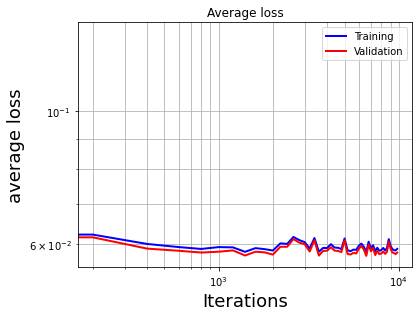

In [256]:
plot_average_loss(traces_MLE)

## Train non-MLE model

train_t shape =  (800000,) 

train_x shape =  (800000, 4) 

Iteration vs average loss
 iteration	 train-set	 valid-set
         0	  0.116824	  0.115104
    199800	  0.058369	  0.058304	  0.059388


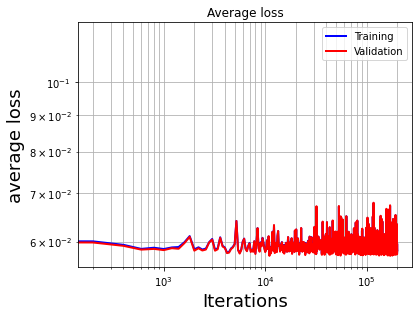

In [270]:
BATCHSIZE=batch_size
traces_nonMLE = ([], [], [], [])
traces_step = 200


n_iterations=200000
traces_nonMLE= train(model=model_nonMLE, 
              optimizer=optimizer_nonMLE, 
              avloss=average_quadratic_loss,
              batch_size=BATCHSIZE, 
              n_iterations=n_iterations, 
              traces=traces_nonMLE, 
              step=traces_step, 
              window=200,
                MLE=False)
plot_average_loss(traces_nonMLE)

### Make sure the train df has the same ranges as the data you want to generate for evaluation

In [289]:
def load_train_df(MLE):
    """ returns the dataframe, can be used if the dataframe is saved in csv format
    of if it is already in dataframe format (e.g. generated in this notebook). """
    # SUBSAMPLE=int(1e5)
    # if isinstance(df_name,str):
    if MLE:
        train_df = pd.read_csv('data/two_parameters_theta_0_20_1000k_Examples_MLE_True.csv', 
                         # nrows=SUBSAMPLE,
                         usecols=['Z','theta','nu', 'N', 'M']
                        )
    else:
        train_df = pd.read_csv('data/two_parameters_theta_0_20_1000k_Examples_MLE_False.csv', 
                 # nrows=SUBSAMPLE,
                 usecols=['Z','theta','nu', 'N', 'M']
                )
    return train_df

train_df_MLE = load_train_df(MLE=True)
train_df_MLE.describe()

,Z,theta,nu,N,M
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,0.869277,10.003908,10.002505,4.992945,4.998255
std,0.337097,5.776635,5.773482,2.581581,2.581333
min,0.000000,0.000003,0.000015,1.000000,1.000000
25%,1.000000,4.997640,5.003678,3.000000,3.000000
50%,1.000000,10.007441,10.005360,5.000000,5.000000
75%,1.000000,15.010142,15.000510,7.000000,7.000000
max,1.000000,19.999931,19.999968,9.000000,9.000000


## Make "on-the-fly" generated evaluation data

Note that this is one advantage of LFI, where one can always generate more synthetic data (for training as well as evaluation), whereas in traditinoal ML, the raining and evaluation data sets are fixed. Here, we generate binned $\theta$ with the same ranges as those of the training set, and constants for $\{ \nu, N, M \}$.

In [290]:
def make_eval_data(Bprime, train_df, nu, N, M, nbins):
    #if MLE true, load the model that was trained on MLE data and vice versa
    # N, M = D
    # nbins=NBINS
    # thetamin,thetamax=0,20
    thetamin=train_df['theta'].min()
    thetamax=train_df['theta'].max()
    thetastep = (thetamax-thetamin) / nbins
    bb    = np.arange(thetamin, thetamax+thetastep, thetastep)#this is just making a vector of thetas
    X     = (bb[1:] + bb[:-1])/2
    tensor = torch.Tensor([[x, nu, N, M] for x in X])
    return tensor, X

### Look at an example of a "on-the-fly" generated evaluation data

In [291]:
eval_data_example, eval_bins_example =make_eval_data(Bprime=100,train_df=train_df_MLE,nu=3, N=1, M=3, nbins=300)
print(eval_data_example[:5])

tensor([[0.0333, 3.0000, 1.0000, 3.0000],
        [0.1000, 3.0000, 1.0000, 3.0000],
        [0.1667, 3.0000, 1.0000, 3.0000],
        [0.2333, 3.0000, 1.0000, 3.0000],
        [0.3000, 3.0000, 1.0000, 3.0000]])


In [47]:
eval_data_example.shape

torch.Size([300, 4])

# Load and Evaluate Trained model at generated data

In [57]:
def usemodel(Bprime, train_df, nu, N,M, MLE, nbins):
    
    #Generate evaluation data at those fixed nu, N, M values
    eval_data, eval_bins =make_eval_data(Bprime,train_df,nu, N,M, nbins)#eval data is indipendent of MLE, since its just constants witha theta variable

    # if MLE==True:
    #     model=model
    #else load the model trained on non-MLE data
    # PATH='models/MLE_TRUE_Regressor_200.0K_training_iter.pt'
    
    #LOAD TRAINED MODEL
    if MLE:
        PATH= 'models/MLE_TRUE_Regressor_200.0K_training_iter.pt'
    else:
        PATH= 'models/MLE_False_Regressor_200.0K_training_iter.pt'
    n_layers = int(BEST_PARAMS["n_layers"]) 
    hidden_size = int(BEST_PARAMS["hidden_size"])
    dropout = float(BEST_PARAMS["dropout"])
    optimizer_name = BEST_PARAMS["optimizer_name"].to_string().split()[1]
    learning_rate =  float(BEST_PARAMS["learning_rate"])
    batch_size = int(BEST_PARAMS["batch_size"])
    model =  RegularizedRegressionModel(
        nfeatures=sample_x.shape[1], 
        ntargets=1,
        nlayers=n_layers, 
        hidden_size=hidden_size, 
        dropout=dropout
        )
    #EVALUATE AT AT EVAL_DATA
    model.load_state_dict(torch.load(PATH) )
    model.eval()
    return model(eval_data).detach().numpy(), eval_bins

# Evaluate model at an example set of "eval_data" points to see the predicted $p$-value ($\hat{p}$)

In [58]:
phat_MLE, phatbins_MLE = usemodel(Bprime=1000,train_df=train_df,nu=3, N=2, M=3, MLE=True, nbins=200)
print(phat_MLE[:5])

[[0.35160586]
 [0.37797815]
 [0.40793738]
 [0.4447972 ]
 [0.45915934]]


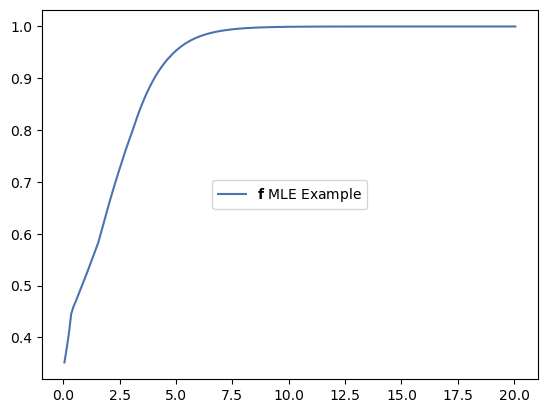

In [63]:
plt.plot(phatbins_MLE, phat_MLE, label=r'$\mathbf{f}$ MLE Example'); 
plt.legend(loc='center'); plt.show()

[[0.06873233]
 [0.18242979]
 [0.26183748]
 [0.38128778]
 [0.4238785 ]]


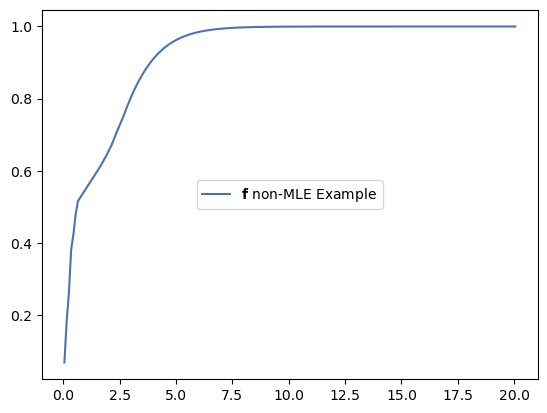

In [64]:
phat_nonMLE, phatbins_nonMLE = usemodel(Bprime=1000,train_df=train_df,nu=3, N=2, M=3, MLE=False, nbins=200)
print(phat_nonMLE[:5])
plt.plot(phatbins_nonMLE, phat_nonMLE, label=r'$\mathbf{f}$ non-MLE Example'); plt.legend(loc='center'); plt.show()

### SAVE TRAINED MODEL (if it's good)

In [65]:
def save_model(MLE):
    if MLE:
        model = model_MLE
    else:
        model = model_nonMLE
    PATH='models/MLE_%s_Regressor_%sK_training_iter.pt' % ( str(MLE), str(n_iterations/1000) )
    torch.save(model.state_dict(),  PATH)

In [66]:
# save_model(MLE=False)

### This is how you load a trained model

In [196]:
#load
PATH='models/MLE_TRUE_Regressor_20.0K_training_iter.pt'
n_layers = int(BEST_PARAMS["n_layers"]) 
hidden_size = int(BEST_PARAMS["hidden_size"])
dropout = float(BEST_PARAMS["dropout"])
optimizer_name = BEST_PARAMS["optimizer_name"].to_string().split()[1]
learning_rate =  float(BEST_PARAMS["learning_rate"])
batch_size = int(BEST_PARAMS["batch_size"])
model =  RegularizedRegressionModel(
    nfeatures=train_x.shape[1], 
    ntargets=1,
    nlayers=n_layers, 
    hidden_size=hidden_size, 
    dropout=dropout
    )
model.load_state_dict(torch.load(PATH) )
#OR
#model=torch.load(PATH)#BUT HERE IT WILL BE A DICT (CANT BE EVALUATED RIGHT AWAY) DISCOURAGED!
model.eval()
print(model)

RegularizedRegressionModel(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=11, bias=True)
    (1): Dropout(p=0.1320798105984151, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=11, out_features=11, bias=True)
    (4): Dropout(p=0.1320798105984151, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=11, out_features=11, bias=True)
    (7): Dropout(p=0.1320798105984151, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=11, out_features=11, bias=True)
    (10): Dropout(p=0.1320798105984151, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=11, out_features=1, bias=True)
    (13): Sigmoid()
  )
)


### You could also evaluate the trained model on the validation data

In [197]:
# nbins=100
# thetamin=train_df['theta'].min()
# thetamax=train_df['theta'].max()
# thetastep = (thetamax-thetamin) / nbins
# bb    = np.arange(thetamin, thetamax+thetastep, thetastep)#this is just making a vector of thetas
# X     = (bb[1:] + bb[:-1])/2
eval_data=torch.Tensor(valid_x)
model.eval()
phat=model(eval_data).detach().numpy()

phat

array([[0.8695913],
       [0.8695913],
       [0.8695913],
       ...,
       [0.8695913],
       [0.8695913],
       [0.8695913]], dtype=float32)

In [71]:
def plot_data_one_nu_with_model(Bprime, thetamin, thetamax, nu, D, MLE, 
                     NBINS,
              FONTSIZE=15,
              func=None,
              fgsize=(10, 6), save_image=False):
    
    # make room for 6 sub-plots
    fig, ax = plt.subplots(nrows=2, 
                           ncols=3, 
                           figsize=fgsize)
    
    # padding
    plt.subplots_adjust(hspace=0.01)
    plt.subplots_adjust(wspace=0.20)
    
    # use flatten() to convert a numpy array of 
    # shape (nrows, ncols) to a 1-d array. 
    ax = ax.flatten()
    
    for j, (N, M) in enumerate(D):
        
        y, bb = make_hist_data(Bprime,
                              thetamin, thetamax,
                              nu, N, M,
                              nbins=NBINS,
                              MLE=True)
    
        ax[j].set_xlim(thetamin-0.5, thetamax-5)
        ax[j].set_ylim(0, 1.03)
        ax[j].set_xlabel(r'$\mathbf{\theta}$', fontsize=FONTSIZE-3)
        ax[j].set_ylabel(r'$\mathbf{E(Z|\theta, \nu)}$', fontsize=FONTSIZE-3)
        
        x = (bb[1:]+bb[:-1])/2
        ax[j].plot(x, y, 'b', lw=2, label='$\mathbf{h}$ MLE', alpha=0.4)
        #h is histogram approximation

        y_nonMLE, bb_nonMLE = make_hist_data(Bprime,
                              thetamin, thetamax,
                              nu, N, M,
                              nbins=NBINS,
                              MLE=False)
        
        
        x_nonMLE = (bb_nonMLE[1:]+bb_nonMLE[:-1])/2
        ax[j].plot(x_nonMLE, y_nonMLE, 'r', lw=2, label='$\mathbf{h}$ non-MLE',alpha=0.4)
        
        
        if func:
            train_df_MLE = load_train_df(MLE=True)
            train_df_nonMLE = load_train_df(MLE=False)
            
            f_MLE, f_bins_MLE = func(Bprime, train_df_MLE, nu, N, M, MLE=True, nbins=NBINS)
            ax[j].plot(x, f_MLE, color='g', lw=2, label='$\mathbf{f}$ MLE', alpha=0.4)
            #f is model approximation
            
            f_nonMLE, f_bins_nonMLE = func(Bprime, train_df_nonMLE, nu, N, M, MLE=False, nbins=NBINS)
            ax[j].plot(x, f_nonMLE, color='c', lw=2, label='$\mathbf{f}$ non-MLE', alpha=0.4)
            
        ax[j].grid(True, which="both", linestyle='-')
        ax[j].text(3.1, 0.42, r'$N, M = %d, %d$' % (N, M), fontsize=font_legend-3
                   # fontsize=FONTSIZE
                  ) 

        ax[j].text(3.1, 0.30, r'$\nu = %5.1f$' % nu, fontsize=font_legend-3
                   # fontsize=FONTSIZE
                  ) 

        ax[j].legend(loc='upper right',fontsize=font_legend-3)
        
    # hide unused sub-plots
    for k in range(j+1, len(ax)):
        ax[k].set_visible(False)
    
    plt.tight_layout()
    if save_image:
        plt.savefig('images/h_MLE_nonMLE_f_MLE_f_nonMLE_one_nu%s.png' % str(nu))
    plt.show()


Compare the histogrammed function $h(\theta, \nu, N, M)$ to the ML prediction functino $f(\theta, \nu, N, M)$ (which is trained to regress $Z$). 

In [72]:
def make_D(train_df):
    Nmin = train_df['N'].min()
    Nmax = train_df['N'].max()
    Mmin = train_df['M'].min()
    Mmax = train_df['M'].max()
    D = [ (N, M) for N in range(Nmin, Nmax) for M in range(Mmin, Mmax)]
    return D[:6]

D = make_D(train_df)
D

[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6)]

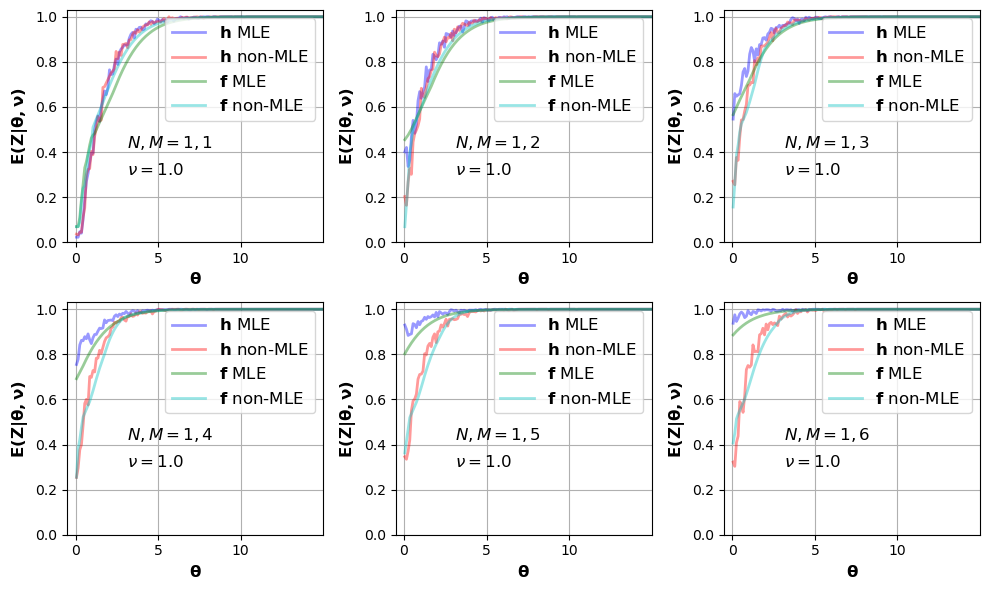

In [74]:
thetamin = train_df['theta'].min()
thetamax = train_df['theta'].max()
plot_data_one_nu_with_model(Bprime=100000, thetamin=thetamin, thetamax=thetamax, 
                 nu=1, D=D, MLE=True, NBINS=200, func=usemodel, save_image=True)

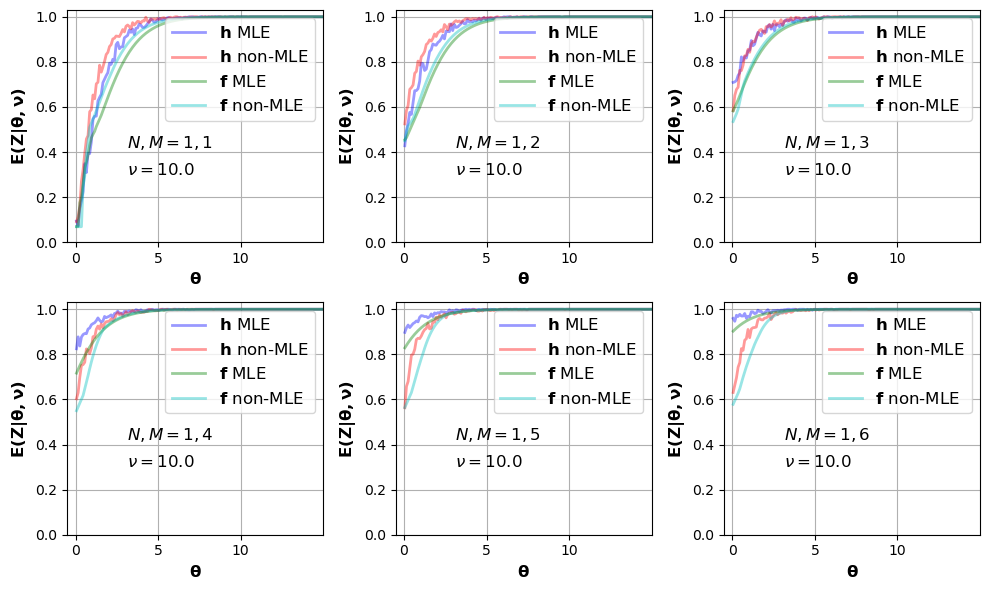

In [76]:
plot_data_one_nu_with_model(Bprime=100000, thetamin=thetamin, thetamax=thetamax, 
                 nu=10, D=D, MLE=True, NBINS=200, func=usemodel, save_image=True)

In [204]:
def plot_data_many_nus_with_model(Bprime, thetamin, thetamax, nu_list, D,
                     NBINS,
              FONTSIZE=15,
              func=None,
              fgsize=(10, 6), save_image=False):
    
    # make room for 6 sub-plots
    fig, ax = plt.subplots(nrows=2, 
                           ncols=2, 
                           figsize=fgsize)
    
    outside=''
    ALPHA=0.8
    TITLE_SIZE=font_legend+1
    
    # padding
    plt.subplots_adjust(hspace=3)
    plt.subplots_adjust(wspace=1)#horizontal distance
    
    # use flatten() to convert a numpy array of 
    # shape (nrows, ncols) to a 1-d array. 
    
    for nu in nu_list:
        
        N, M = D
        y, bb = make_hist_data(Bprime,
                              thetamin, thetamax,
                              nu, N, M,
                              nbins=NBINS,
                              MLE=True)
    

        if nu > 20:
            outside = outside + r' ($>$ train data)'
        
        x = (bb[1:]+bb[:-1])/2
        ax[0,0].plot(x, y, lw=2, label=r'$\nu= %s$ %s' % (str(nu), outside), alpha=ALPHA)
        ax[0,0].set_title(r'$\mathbf{h}$ MLE', fontsize=TITLE_SIZE)
        #h is histogram approximation

        y_nonMLE, bb_nonMLE = make_hist_data(Bprime,
                              thetamin, thetamax,
                              nu, N, M,
                              nbins=NBINS,
                              MLE=False)
        
        
        x_nonMLE = (bb_nonMLE[1:]+bb_nonMLE[:-1])/2

        ax[1,0].plot(x_nonMLE, y_nonMLE, lw=2, label=r'$\nu= %s$ %s' % (str(nu), outside) ,alpha=ALPHA)
        ax[1,0].set_title(r'$\mathbf{h}$ non-MLE',fontsize=TITLE_SIZE)
        
        if func:
            #load the correct dataframe
            train_df_MLE = load_train_df(MLE=True)
            train_df_nonMLE = load_train_df(MLE=False)
            
            f_MLE, f_bins_MLE = func(Bprime, train_df_MLE, nu, N, M, MLE=True, nbins=NBINS)
            ax[0,1].plot(x, f_MLE, lw=2, label=r'$\nu= %s$ %s' % (str(nu), outside), alpha=ALPHA)
            ax[0,1].set_title(r'$\mathbf{f}$ MLE',fontsize=TITLE_SIZE)
            #f is model approximation
            
            f_nonMLE, f_bins_nonMLE = func(Bprime, train_df_nonMLE, nu, N, M, MLE=False, nbins=NBINS)
            ax[1,1].plot(f_bins_nonMLE, f_nonMLE, lw=2, label=r'$\nu= %s$ %s' % (str(nu), outside), alpha=ALPHA)
            ax[1,1].set_title(r'$\mathbf{f}$ non-MLE',fontsize=TITLE_SIZE)
        
        
        for i in range(ax.shape[0]):
            for j in range(ax.shape[1]):
                ax[i,j].set_xlim(thetamin-0.5, thetamax-7)
                ax[i,j].set_ylim(0.2, 1.03)
                ax[i,j].set_xlabel(r'$\mathbf{\theta}$', fontsize=FONTSIZE-2)
                ax[i,j].set_ylabel(r'$\mathbf{E(Z|\theta, \nu)}$', fontsize=FONTSIZE-2)
                ax[i,j].text(2, 0.5, r'$N, M = %d, %d$' % (N, M), fontsize=font_legend-3
                           # fontsize=FONTSIZE
                          ) 
                
                ax[i,j].grid(True, which="both", linestyle='-')

                ax[i,j].legend(loc='center right',fontsize=font_legend-3)
                ax[i,j].patch.set_edgecolor('black')  

                ax[i,j].patch.set_linewidth('1')  
        # ax[j].text(3.1, 0.30, r'$\nu = %5.1f$' % nu, fontsize=font_legend-3
        #            # fontsize=FONTSIZE
        #           ) 

        
        
    # hide unused sub-plots
#     for k in range(j+1, len(ax)):
#         ax[k].set_visible(False)
    
    plt.tight_layout()
    if save_image:
        plt.savefig('images/h_MLE_nonMLE_f_MLE_f_nonMLE_many_nus.png')
    plt.show()


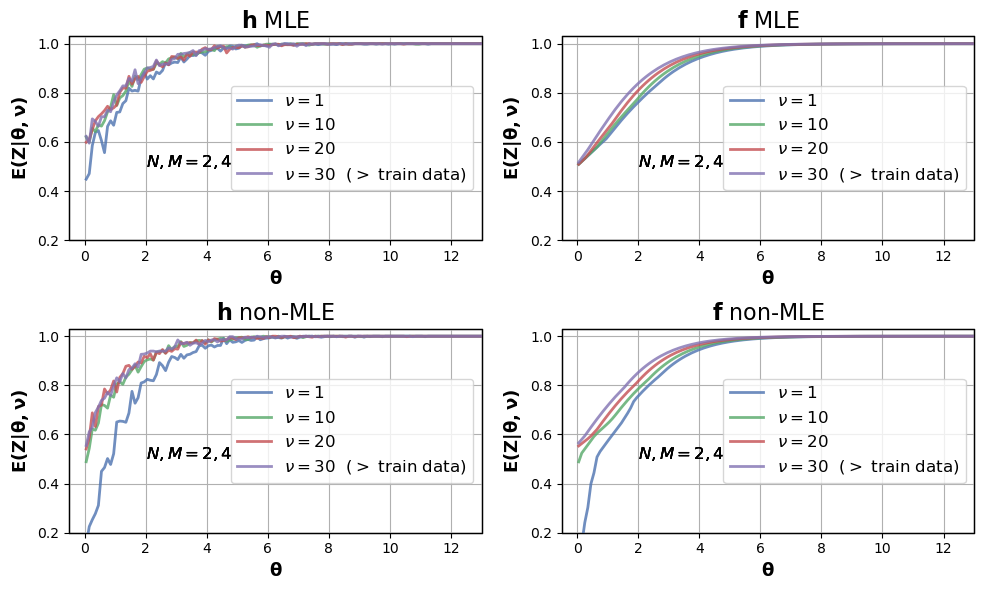

In [206]:
D = (2,4)
nu_list = [1,10, 20, 30]
plot_data_many_nus_with_model(Bprime=100000, thetamin=0, thetamax=20, nu_list=nu_list, D=D,
                     NBINS=200,
              FONTSIZE=15,
              func=usemodel,
              fgsize=(10, 6), save_image=False
                             )

-------------------
--------

# Learning to Pivot

We observe in the plots above that in the case of MLE, $\mathbf{h}$ has very little sensitivity to $\nu$, as expected, whereas in the non-MLE case, $\mathbf{h}$ has a strong dependence on $\nu$. 

Since $\nu$ is not known precisely from first principles, it is good that we see that our models $\mathbf{f}$ have given predictions that agree with the histogrammed predictions even in regions outside the region of values of the nuissance parameters used in the training. This is because systematic uncertainties are usually present when the training data is not representative of the real data. Therefore, statisticians have always been interested in forming robust inference techniques that are independent based on *pivots* - quantities whose distributions are independent of nuissance parameters.

The desired outcome is that we want to enforce $\mathbf{f}(\theta)$ to be pivotal - i.e. for its distribution to be independent of $\nu$. In other words we would like a function $\lambda(\theta,\nu, N,M)$ such that the expectation $E \left( y=Z|x=\{\theta, \nu, N, M\} \right)$ is independent of nuissance parameter $\nu$. One example is that we can impose this condition by

$$\frac{\partial E(Z|\theta,\nu,N,M)}{\partial \nu} =0$$
in our loss function for all $\theta, N,M$. This means our loss function will become

$$L(t, \mathbf{f}) =  \big( y - \mathbf{f}(\theta, \nu, N, M) \big) ^2 - \frac{\kappa}{2} \ \left\| \frac{\partial \mathbf{f}(\theta,\nu,N,M)}{\partial \nu} \right\|^2$$

Where $\kappa$ will be a constant and tunable hyperparameter. The operation to square the derivaive is because the derivative will be a vectory (an array), so squaring it (or taking the dot product) will reduce it to a single scalar value.

In [50]:
train_df.head()

,Unnamed: 0,Z,theta,nu,N,M
0,0,1,19.019560,14.400012,8,4
1,1,1,7.610256,10.087596,8,8
2,2,1,11.231479,17.182742,6,9
3,3,1,12.486063,19.537368,8,5
4,4,1,1.195603,12.801719,5,1


In [51]:
train_t, train_x, test_t,  test_x = getwholedata(MLE_or_nonMLE=True, valid=False)
print(train_x)

train_t shape =  (800000,) 

train_x shape =  (800000, 4) 

[[18.11434453  5.78630474  1.          7.        ]
 [ 1.55074438  3.38442206  5.          7.        ]
 [ 3.91331087  7.15318952  2.          5.        ]
 ...
 [10.93512302  2.84093164  6.          8.        ]
 [15.88748852 11.80727392  6.          4.        ]
 [ 8.28682876  2.63362498  4.          4.        ]]


$\nu$ is the second column in the features data

In [36]:
n_layers_pivot, hidden_size_pivot, dropout_pivot, optimizer_name_pivot, learning_rate_pivot, batch_size_pivot, model_nonMLE_pivot, optimizer_nonMLE_pivot = initiate_whose_model('Ali', MLE=False)
print(model_nonMLE_pivot)

RegularizedRegressionModel(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=11, bias=True)
    (1): Dropout(p=0.1320798105984151, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=11, out_features=11, bias=True)
    (4): Dropout(p=0.1320798105984151, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=11, out_features=11, bias=True)
    (7): Dropout(p=0.1320798105984151, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=11, out_features=11, bias=True)
    (10): Dropout(p=0.1320798105984151, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=11, out_features=1, bias=True)
    (13): Sigmoid()
  )
)


### Aside: a few words on pytorch's autograd (more on this in https://github.com/AliAlkadhim/LFI_HEP/blob/main/src/Two_params/autograd2.ipynb)

for the example below, we have $F=a b$ so $\frac{\partial F}{\partial a} = b = 20$. Let's see if it works:

In [112]:
a = torch.tensor(10., requires_grad=True)
b = torch.tensor(20., requires_grad=True)
F = a* b
F.backward()
a.grad

tensor(20.)

Great, it works! Now let's see if it works for tensors or arrays (non-scalars)

In [113]:
a = torch.tensor([10.,10.], requires_grad=True)
b = torch.tensor([20.,20.], requires_grad=True)
F = a* b
F.backward()
a.grad

RuntimeError: grad can be implicitly created only for scalar outputs

It doesn't work. See https://abishekbashyall.medium.com/playing-with-backward-method-in-pytorch-bd34b58745a0 if you want to learn more. We can work our way around it by passing a `gradient` argument to `backward()` with the same shape as `F`

In [114]:
a = torch.tensor([10.,10.], requires_grad=True)
b = torch.tensor([20.,20.], requires_grad=True)
F = a* b
F.backward(gradient=torch.tensor([1.,1.]))
a.grad

tensor([20., 20.])

ta-da! we can also do

In [115]:
a = torch.tensor([10.,10.], requires_grad=True)
b = torch.tensor([20.,20.], requires_grad=True)
F = a* b
F.backward(gradient=torch.ones(F.shape))
a.grad

tensor([20., 20.])

In our case $x$ and $\nu$ are leaf nodes and so their gradients will not be accumulated, and $f$ is not a leaf node. We have to retain_

In [319]:
def RMS(v):
    return (torch.mean(v**2))**0.5
    
def average_quadratic_loss_pivot(f, t, x, df_dnu):
    # f and t must be of the same shape
    return  torch.mean((f - t)**2) - RMS(df_dnu)

def validate(model, avloss, inputs, targets, df_dnu):
    # make sure we set evaluation mode so that any training specific
    # operations are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x and t
        x = torch.from_numpy(inputs).float()
        t = torch.from_numpy(targets).float()
        # remember to reshape!
        o = model(x).reshape(t.shape)
    return avloss(o, t, x, df_dnu)

In [320]:
def train_pivotal(model, optimizer, avloss,
          batch_size, 
          n_iterations, traces, 
          step, window, MLE):
    
    # to keep track of average losses
    xx, yy_t, yy_v, yy_v_avg = traces
    
    
    if MLE:
        train_t, train_x, test_t,  test_x = getwholedata(MLE_or_nonMLE=True, valid=False)
    else:
        train_t, train_x, test_t,  test_x = getwholedata(MLE_or_nonMLE=False, valid=False)
        
    n = len(test_x)
    print('Iteration vs average loss')
    print("%10s\t%10s\t%10s" % \
          ('iteration', 'train-set', 'valid-set'))
    
    # training_set_features, training_set_targets, evaluation_set_features, evaluation_set_targets = get_data_sets(simulate_data=False, batchsize=batch_size)
    
    for ii in range(n_iterations):

        # set mode to training so that training specific 
        # operations such as dropout are enabled.

        
        # model.eval()
        # get a random sample (a batch) of data (as numpy arrays)
        
        #Harrison-like Loader
        batch_x, batch_t = get_features_training_batch(train_x, train_t, batch_size)
        
        #Or Ali's Loader
        # batch_x, batch_t = next(training_set_features()), next(training_set_targets())
        # batch_x_eval, batch_t_eval = next(evaluation_set_features()), next(evaluation_set_targets())

        # with torch.no_grad(): # no need to compute gradients 
            # wrt. x and t
        x = torch.from_numpy(batch_x).float()
        # print('x is leaf: ', x.is_leaf)
        x.requires_grad_(True)
        # x.retain_grad()
        # print('x is leaf after retain: ', x.is_leaf)
        # x.requires_grad_(True)
        # x.retain_grad()
        f = model(x)
        f = f.view(-1)
        f = f @ f.t()
        # f = torch.tensor(f, requires_grad=True)
        # print('f shape: ', f.shape)
        # print('f is leaf: ', f.is_leaf)
        
        # f_2 = f**2
        # print('f2 shape', f_2.shape)
        # nu = torch.autograd.Variable( x[:,1], requires_grad=True)
        
        # nu=torch.autograd.Variable(x[:,1], requires_grad=True)
        nu=torch.tensor(x[:,1], requires_grad=True)
        # print(type(nu))
 
        # nu.retain_grad()
        
        # print('nu shape: ', nu.shape)
        # print('nu is leaf: ', nu.is_leaf)
        # print('nu type', type(nu))
        
        
        # WE NEED TO RETAIN_GRAD ON NON-LEAF NODES 
        f.retain_grad()
        f.backward(gradient=torch.ones_like(f), retain_graph=True)

        #or f.backward(torch.ones_like(f) , retain, graph
        # we cant do f.backward() here because backeard() can only be called for scalara
        # and f here will be a tensor of shape torch.Size([1000, 1]
        #e.g. see https://abishekbashyall.medium.com/playing-with-backward-method-in-pytorch-bd34b58745a0
        
        # PyTorch accumulates the gradient in default, we need to clear the previous
        # values
        # df_dnu = nu.grad
        df_dx = x.grad
        # print('df_dnu =', df_dnu)
        # print('df_dx =', df_dx)
        # print('df_dx shape :', df_dx.shape)
        #clear the gradient after you take it
        df_dnu = df_dx[:,1]
        # print('df_dnu shape: ', df_dnu.shape)
        x.grad.zero_()
        # break
        
        
        
        
        
        with torch.no_grad():
            x = torch.from_numpy(batch_x).float()
            t = torch.from_numpy(batch_t).float()   
        
        model.train()
        

        

        outputs = model(x).reshape(t.shape)
   
        # compute a noisy approximation to the average loss
        empirical_risk = avloss(outputs, t, x, df_dnu)
        
        # use automatic differentiation to compute a 
        # noisy approximation of the local gradient
        optimizer.zero_grad()       # clear previous gradients
        empirical_risk.backward()   # compute gradients
        
        # finally, advance one step in the direction of steepest 
        # descent, using the noisy local gradient. 
        optimizer.step()            # move one step
        
        if ii % step == 0:
            
            # this is an example of an x tensor
            # [17.3352, 10.7722,  6.0000,  8.0000],
            #[16.7822, 13.3260,  8.0000,  4.0000],
            #using Harrison-like loader
            acc_t = validate(model, avloss, train_x[:n], train_t[:n], df_dnu)
            acc_v = validate(model, avloss, test_x[:n], test_t[:n], df_dnu)
            
            #using Ali's loader
            # acc_t = validate(model, avloss, batch_x, batch_t) 
            # acc_v = validate(model, avloss, batch_x_eval, batch_t_eval)
            

            yy_t.append(acc_t)
            yy_v.append(acc_v)
            
            # compute running average for validation data
            len_yy_v = len(yy_v)
            if   len_yy_v < window:
                yy_v_avg.append( yy_v[-1] )
            elif len_yy_v == window:
                yy_v_avg.append( sum(yy_v) / window )
            else:
                acc_v_avg  = yy_v_avg[-1] * window
                acc_v_avg += yy_v[-1] - yy_v[-window-1]
                yy_v_avg.append(acc_v_avg / window)
                        
            if len(xx) < 1:
                xx.append(0)
                print("%10d\t%10.6f\t%10.6f" % \
                      (xx[-1], yy_t[-1], yy_v[-1]))
            else:
                xx.append(xx[-1] + step)
                    
                print("\r%10d\t%10.6f\t%10.6f\t%10.6f" % \
                          (xx[-1], yy_t[-1], yy_v[-1], yy_v_avg[-1]), 
                      end='')
            
    print()      
    return (xx, yy_t, yy_v, yy_v_avg)

In [322]:
BATCHSIZE=batch_size
traces_nonMLE_pivot = ([], [], [], [])
traces_step = 200


n_iterations=20000
traces_nonMLE_pivot= train_pivotal(model=model_nonMLE_pivot, 
              optimizer=optimizer_nonMLE_pivot, 
              avloss=average_quadratic_loss_pivot,
              batch_size=BATCHSIZE, 
              n_iterations=n_iterations, 
              traces=traces_nonMLE_pivot, 
              step=traces_step, 
              window=200,
                MLE=False)


train_t shape =  (800000,) 

train_x shape =  (800000, 4) 

Iteration vs average loss
 iteration	 train-set	 valid-set
         0	  0.057958	  0.057423


/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


     19800	  0.058580	  0.058094	  0.058094


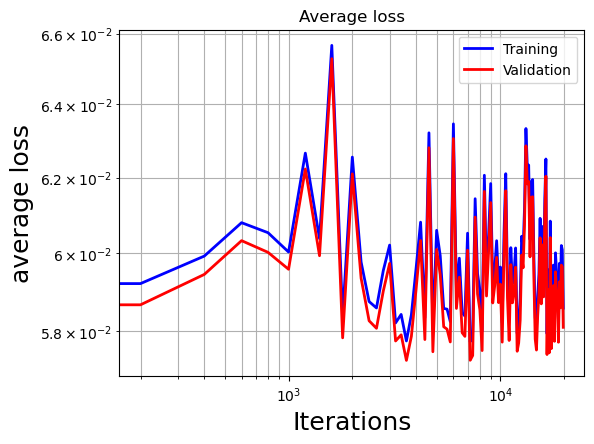

In [323]:
plot_average_loss(traces_nonMLE_pivot)

In [313]:
PATH='models/PIVOT_MLE_False_Regressor_%sK_training_iter.pt' % str(n_iterations/100)
torch.save(model_nonMLE_pivot.state_dict(),  PATH)

In [324]:
def usemodel_with_pivot(Bprime, train_df, nu, N,M, MLE_or_pivot, nbins):
    
    #Generate evaluation data at those fixed nu, N, M values
    eval_data, eval_bins =make_eval_data(Bprime,train_df,nu, N,M, nbins)#eval data is indipendent of MLE, since its just constants witha theta variable

    # if MLE==True:
    #     model=model
    #else load the model trained on non-MLE data
    # PATH='models/MLE_TRUE_Regressor_200.0K_training_iter.pt'
    
    #LOAD TRAINED MODEL
    if MLE_or_pivot=='MLE':
        PATH= 'models/MLE_TRUE_Regressor_200.0K_training_iter.pt'
    elif MLE_or_pivot=='nonMLE':
        PATH= 'models/MLE_False_Regressor_200.0K_training_iter.pt'
    elif MLE_or_pivot=='PIVOT':
        PATH='models/PIVOT_MLE_False_Regressor_200.0K_training_iter.pt'
    n_layers = int(BEST_PARAMS["n_layers"]) 
    hidden_size = int(BEST_PARAMS["hidden_size"])
    dropout = float(BEST_PARAMS["dropout"])
    optimizer_name = BEST_PARAMS["optimizer_name"].to_string().split()[1]
    learning_rate =  float(BEST_PARAMS["learning_rate"])
    batch_size = int(BEST_PARAMS["batch_size"])
    model =  RegularizedRegressionModel(
        nfeatures=sample_x.shape[1], 
        ntargets=1,
        nlayers=n_layers, 
        hidden_size=hidden_size, 
        dropout=dropout
        )
    #EVALUATE AT AT EVAL_DATA
    model.load_state_dict(torch.load(PATH) )
    model.eval()
    return model(eval_data).detach().numpy(), eval_bins

[[0.12251904]
 [0.22194189]
 [0.2433153 ]
 [0.2855224 ]
 [0.34608954]]


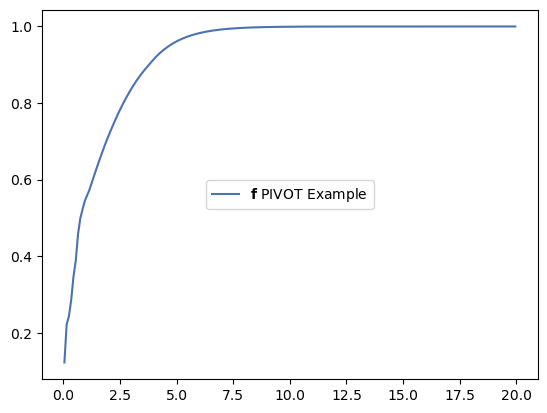

In [295]:
phat_PIVOT, phatbins_PIVOT = usemodel_with_pivot(Bprime=1000,train_df=train_df,nu=3, N=2, M=3, MLE_or_pivot='PIVOT', nbins=200)
print(phat_PIVOT[:5])
plt.plot(phatbins_PIVOT, phat_PIVOT, label=r'$\mathbf{f}$ PIVOT Example'); plt.legend(loc='center'); plt.show()

In [334]:
def plot_data_many_nus_with_model_pivot(Bprime, thetamin, thetamax, nu_list, D,
                     NBINS,
              FONTSIZE=15,
              func=None,
              fgsize=(30, 22), save_image=False):
    
    # make room for 6 sub-plots
    fig, ax = plt.subplots(nrows=2, 
                           ncols=3, 
                           figsize=fgsize)
    
    outside=''
    ALPHA=0.8
    TITLE_SIZE=font_legend+1
    
    # padding
    # plt.subplots_adjust(hspace=3)
    plt.subplots_adjust(wspace=1)#horizontal distance
    
    # use flatten() to convert a numpy array of 
    # shape (nrows, ncols) to a 1-d array. 
    
    for nu in nu_list:
        
        N, M = D
        y, bb = make_hist_data(Bprime,
                              thetamin, thetamax,
                              nu, N, M,
                              nbins=NBINS,
                              MLE=True)
    

        if nu > 20:
            outside =  r' ($>$ train data)'
            
        
        x = (bb[1:]+bb[:-1])/2
        ax[0,0].plot(x, y, lw=2, label=r'$\nu= %s$ %s' % (str(nu), outside), alpha=ALPHA)
        ax[0,0].set_title(r'$\mathbf{h}$ MLE', fontsize=TITLE_SIZE)
        #h is histogram approximation

        y_nonMLE, bb_nonMLE = make_hist_data(Bprime,
                              thetamin, thetamax,
                              nu, N, M,
                              nbins=NBINS,
                              MLE=False)
        
        
        x_nonMLE = (bb_nonMLE[1:]+bb_nonMLE[:-1])/2

        ax[1,0].plot(x_nonMLE, y_nonMLE, lw=2, label=r'$\nu= %s$ %s' % (str(nu), outside) ,alpha=ALPHA)
        ax[1,0].set_title(r'$\mathbf{h}$ non-MLE',fontsize=TITLE_SIZE)
        
        if func:
            #load the correct dataframe
            train_df_MLE = load_train_df(MLE=True)
            train_df_nonMLE = load_train_df(MLE=False)
            
            #plot MLE models
            f_MLE, f_bins_MLE = func(Bprime, train_df_MLE, nu, N, M, MLE_or_pivot='MLE', nbins=NBINS)
            ax[0,1].plot(x, f_MLE, lw=2, label=r'$\nu= %s$ %s' % (str(nu), outside), alpha=ALPHA)
            ax[0,1].set_title(r'$\mathbf{f}$ MLE',fontsize=TITLE_SIZE)
            #f is model approximation
            
            #plot non-MLE models
            f_nonMLE, f_bins_nonMLE = func(Bprime, train_df_nonMLE, nu, N, M, MLE_or_pivot='nonMLE', nbins=NBINS)
            ax[1,1].plot(f_bins_nonMLE, f_nonMLE, lw=2, label=r'$\nu= %s$ %s' % (str(nu), outside), alpha=ALPHA)
            ax[1,1].set_title(r'$\mathbf{f}$ non-MLE',fontsize=TITLE_SIZE)
            
            
            #plot pivotal  MLE models
            f_pivot_MLE, f_bins_pivot_MLE = func(Bprime, train_df_MLE, nu, N, M, MLE_or_pivot='PIVOT', nbins=NBINS)
            ax[0,2].plot(f_bins_pivot_MLE, f_pivot_MLE, lw=2, label=r'$\nu= %s$ %s' % (str(nu), outside), alpha=ALPHA)
            ax[0,2].set_title(r'$\mathbf{f-pivot}$ MLE',fontsize=TITLE_SIZE)
            
            #plot pivotal non MLE models
            f_pivot_nonMLE, f_bins_pivot_nonMLE = func(Bprime, train_df_nonMLE, nu, N, M, MLE_or_pivot='PIVOT', nbins=NBINS)
            ax[1,2].plot(f_bins_pivot_nonMLE, f_pivot_nonMLE, lw=2, label=r'$\nu= %s$ %s' % (str(nu), outside), alpha=ALPHA)
            ax[1,2].set_title(r'$\mathbf{f-pivot}$ non-MLE',fontsize=TITLE_SIZE)
        
        
        for i in range(ax.shape[0]):
            for j in range(ax.shape[1]):
                ax[i,j].set_xlim(thetamin-0.5, thetamax-7)
                ax[i,j].set_ylim(0.2, 1.03)
                ax[i,j].set_xlabel(r'$\mathbf{\theta}$', fontsize=FONTSIZE)
                ax[i,j].set_ylabel(r'$\mathbf{E(Z|\theta, \nu)}$', fontsize=FONTSIZE)
                ax[i,j].text(2, 0.5, r'$N, M = %d, %d$' % (N, M), fontsize=font_legend-3
                           # fontsize=FONTSIZE
                          ) 
                
                ax[i,j].grid(True, which="both", linestyle='-')

                ax[i,j].legend(loc='center right',fontsize=font_legend-3)
                ax[i,j].patch.set_edgecolor('black')  

                ax[i,j].patch.set_linewidth('1')  
        # ax[j].text(3.1, 0.30, r'$\nu = %5.1f$' % nu, fontsize=font_legend-3
        #            # fontsize=FONTSIZE
        #           ) 

        
        
    # hide unused sub-plots
#     for k in range(j+1, len(ax)):
#         ax[k].set_visible(False)
    
    plt.tight_layout()
    if save_image:
        plt.savefig('images/h_MLE_nonMLE_f_MLE_f_nonMLE_many_nus_PIVOT.png')
    plt.show()


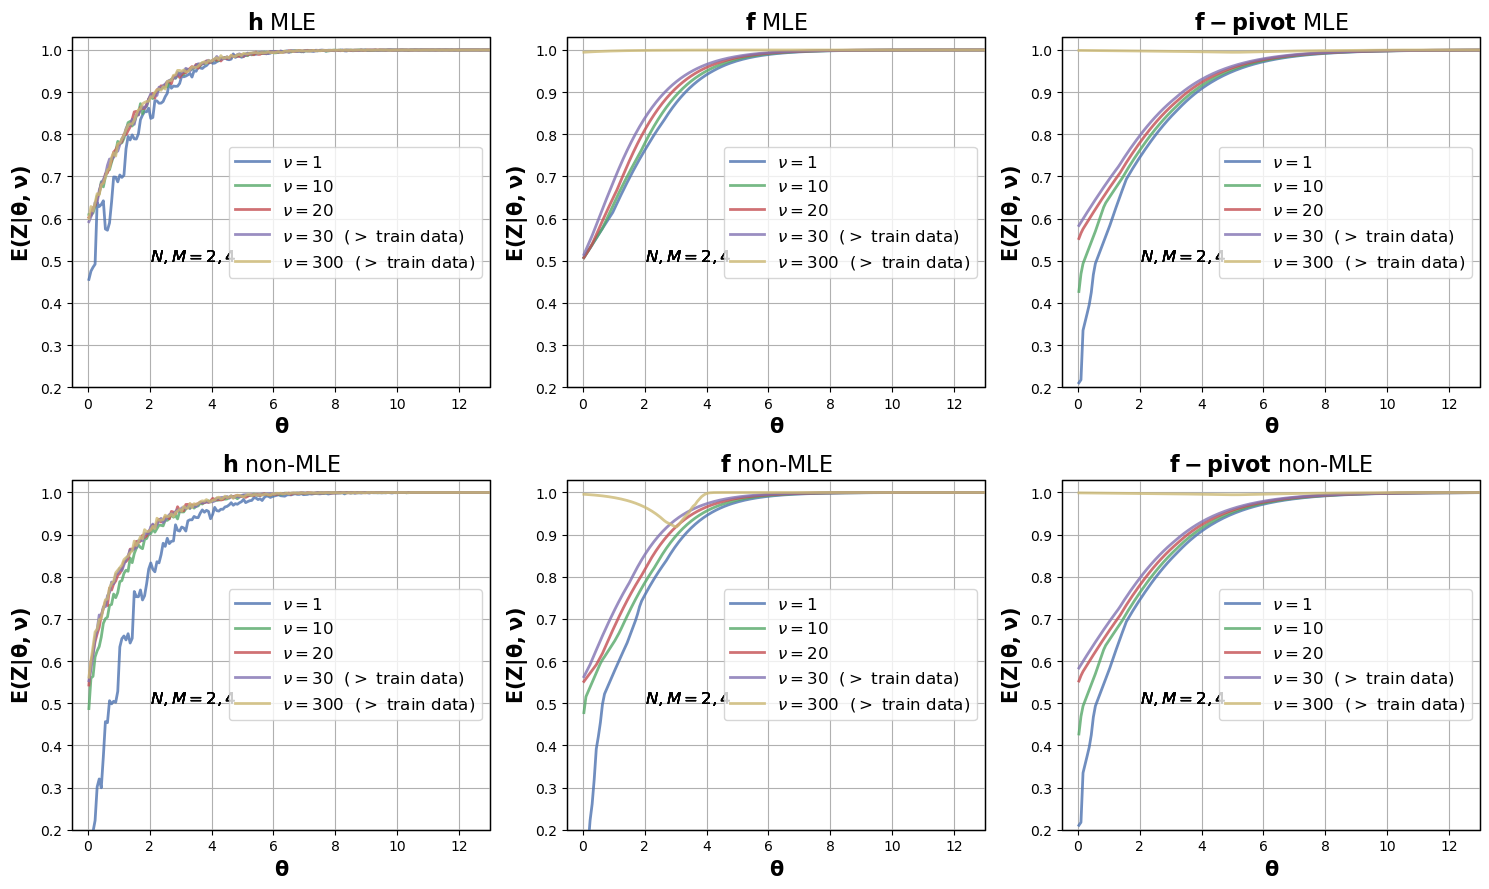

In [336]:
D = (2,4)
nu_list = [1,10, 20, 30, 300]
plot_data_many_nus_with_model_pivot(Bprime=1000000, thetamin=0, thetamax=20, nu_list=nu_list, D=D,
                     NBINS=300,
              FONTSIZE=15,
              func=usemodel_with_pivot,
              fgsize=(15, 9), save_image=True
                             )

### Modify the tuning workflow to tune $\kappa$ in our ivotal loss function

In [ ]:
def average_quadratic_loss_pivot(f, t, x, df_dnu, kappa):
    # f and t must be of the same shape
    return  torch.mean((f - t)**2) - kappa/2 * torch.mean(df_dnu)

def validate(model, avloss, inputs, targets, df_dnu):
    # make sure we set evaluation mode so that any training specific
    # operations are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x and t
        x = torch.from_numpy(inputs).float()
        t = torch.from_numpy(targets).float()
        # remember to reshape!
        o = model(x).reshape(t.shape)
    return avloss(o, t, x, df_dnu)

# we dont want to tune the old parameters so just load them
n_layers = int(BEST_PARAMS["n_layers"]) 
hidden_size = int(BEST_PARAMS["hidden_size"])
dropout = float(BEST_PARAMS["dropout"])
optimizer_name = BEST_PARAMS["optimizer_name"].to_string().split()[1]
learning_rate =  float(BEST_PARAMS["learning_rate"])
batch_size = int(BEST_PARAMS["batch_size"])
    
class Engine_kappa:
    """loss, training and evaluation"""
    def __init__(self, model, optimizer, batch_size, kappa):
                 #, device):
        self.model = model
        #self.device= device
        self.optimizer = optimizer
        self.batch_size=batch_size
        self.kappa=kappa
        
    #the loss function returns the loss function. It is a static method so it doesn't need self
    # @staticmethod
    # def loss_fun(targets, outputs):
    #   tau = torch.rand(outputs.shape)
    #   return torch.mean(torch.where(targets >= outputs, 
    #                                   tau * (targets - outputs), 
    #                                   (1 - tau)*(outputs - targets)))

#     This loss combines a Sigmoid layer and the BCELoss in one single class. This version is more numerically stable than using a plain Sigmoid followed by a BCELoss as, 
#     by combining the operations into one layer

    def train(self, x, t):
        """the training function: takes the training dataloader"""
        self.model.train()
        final_loss = 0
        for iteration in range(n_iterations):
            self.optimizer.zero_grad()
            batch_x, batch_t = get_features_training_batch(x, t,  self.batch_size)#x and t are train_x and train_t

            # with torch.no_grad():
            inputs=torch.from_numpy(batch_x).float()
            targets=torch.from_numpy(batch_t).float()
            outputs = self.model(inputs)
            loss = average_quadratic_loss_pivot(outputs, targets, inputs)
            loss.backward()
            self.optimizer.step()
            final_loss += loss.item()

        return final_loss / self.batch_size
    
    def evaluate(self, x, t):
        """the training function: takes the training dataloader"""
        self.model.eval()
        final_loss = 0
        for iteration in range(n_iterations):
            batch_x, batch_t = get_features_training_batch(x, t,  self.batch_size)#x and t are train_x and train_t

            # with torch.no_grad():            
            inputs=torch.from_numpy(batch_x).float()
            targets=torch.from_numpy(batch_t).float()
            outputs = self.model(inputs)
            loss =average_quadratic_loss(outputs, targets, inputs)
            final_loss += loss.item()
        return final_loss / self.batch_size



EPOCHS=1
def run_train_pivot(params, save_model=False):
    """For tuning the parameters"""

    model =  RegularizedRegressionModel(
              nfeatures=train_x.shape[1], 
                ntargets=1,
                nlayers=params["nlayers"], 
                hidden_size=params["hidden_size"],
                dropout=params["dropout"]
                )
    # print(model)
    

    learning_rate= params["learning_rate"]
    optimizer_name = params["optimizer_name"]
    
    # optimizer = torch.optim.Adam(model.parameters(), lr=params["learning_rate"]) 
    
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=learning_rate)
    
    eng=Engine(model, optimizer, batch_size=params["batch_size"])
    best_loss = np.inf
    early_stopping_iter=10
    early_stopping_coutner=0

    for epoch in range(EPOCHS):
        train_loss = eng.train(train_x, train_t)
        valid_loss=eng.evaluate(test_x, test_t)

        print(f"{epoch} \t {train_loss} \t {valid_loss}")
        if valid_loss<best_loss:
            best_loss=valid_loss
            if save_model:
                model.save(model.state_dict(), "model_m.bin")
        else:
            early_stopping_coutner+=1
        if early_stopping_coutner > early_stopping_iter:
            break
    return best_loss

# run_train()

def objective_pivot(trial):
    params = {
      "kappa": trial.suggest_int("kappa",1,13)

    }
    # all_losses=[]

    temp_loss = run_train(params,save_model=False)
    # all_losses.append(temp_loss)
    return temp_loss

def tune_hyperparameters_pivot():
    print('Getting best hyperparameters')
    study=optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=10)
    best_trial = study.best_trial
    print('best model parameters', best_trial.params)

    best_params=best_trial.params#this is a dictionary
    filename='best_params/kappa_tuned.csv'
    param_df=pd.DataFrame({
                            'n_layers':best_params["nlayers"], 
                            'hidden_size':best_params["hidden_size"], 
                            'dropout':best_params["dropout"],
                            'optimizer_name':best_params["optimizer_name"],
                            'learning_rate': best_params["learning_rate"], 
                            'batch_size':best_params["batch_size"] },
                                    index=[0]
    )

    param_df.to_csv(filename)   

------------------
-----------------
# More Discussions

One simple example which is paradoxical is the following: suppose we have our usual likelihood 
$$L(\theta, \nu)= \frac{e^{-(\theta+\nu)} (\theta+\nu)^N }{N !} \ \frac{e^{-\nu} \nu^M}{M !} \tag{20} $$ and we observe $N=M=0$ so that the likelihood becomes $ L(\theta, \nu)= e^{-(\theta+\nu)} e^{-\nu} $. Suppose that now we wish to make an inference on $\theta$. It should make sense that if we know for a fact that there is no background events (since $M=0$), that the likelihood should not depend on the mean background (since there is no backround to begin with). [Feldman and Cousins](https://arxiv.org/pdf/physics/9711021v2.pdf) were aware of this issue and assigned the problem to be the incorrect interpretation of the intervals as Bayesian intervals.

A very closely related problem is the existence of a signal and background densities, say both depending on POI $\theta$, and the likelihood will be given by

$$ L(\theta) = \prod_{i=1}^{N_{obs}} \theta S(x_i) + (1-\theta) B(x_i)$$
where the likelihood $L(\theta)$ is the probability for obtaining the observation $x$ from either a signal or background distribution, where $\theta$ is an unknown proportion of signal (since real events come as a mixture of signal and background), and we would like to infer about the value of this parameter of interest. In the presense of nuissance parameter $\nu$ the likelihood becomes

$$ L(\theta,\nu) = \prod_{i=1}^{N_{obs}} \theta S(x_i|\nu) + (1-\theta) B(x_i|\nu)$$


# More ideas

We can test this technique in a real case physics LFI scenario by generating pythia data on the fly for signal and background with unknown nuissance parameter and making inferences on the POI

In [285]:
eval_data

NameError: name 'eval_data' is not defined

In [233]:
x = torch.tensor([2.,2], requires_grad=True)
type(x)

torch.Tensor

In [240]:
f = x @ x.t()
print(f)
f.backward()
x.grad

tensor(8., grad_fn=<DotBackward>)


tensor([4., 4.])